# Quantum Machine Learning Methods

**On this notebook**:

> The intent of this notebook is to unify an introduction to libraries and methods that will be used and defined to implement parametrized quantum circuits, with which to implement Quantum Neural Netorks, Eigensolvers, etc.
> Different explored approaches will be presented and benchamrked, with a focus on equivariant techniques. The collected definitive methods are then written in the modules folder, from where they can be imported.

Quantum Machine Learning as a field is very broad, as it is not well defined or constrained to some particular architectures. But for our purposes, the generic implementation of our considered quantum machine learning models will be done within a quantum circuit formalism. Therefore, given some input $\vec{x}$ and variational parameters $\vec{\theta}$, and finally a fixed measurement operator $\hat{O}$, any of our models is of the form:

<!--- $$\langle 0|  U(\vec{x}, \vec{\theta})^\dag \hat{O} U(\vec{x}, \vec{\theta})|0 \rangle$$ --->


$$f(\vec{x}, \vec{\theta} ) = \langle 0|^{\otimes N}  U_N(\vec{x}, \vec{\theta})^\dag \hat{O} U_N(\vec{x}, \vec{\theta})|0 \rangle^{\otimes N}$$

With $N$ the number of qubits.

So our models represent a function of some input $\vec{x}$ which is parametrized by some parameters $\vec{\theta}$, which ideally will allow us to approximate a desired function $f_{c}(\vec{x})$ by finding adequate parameters through some "training".

## Qibo

Qibo is a usefull full-stack framework for quantum computing, which we will use to implement our methods. [[References]](https://qibo.science/qibo/stable/appendix/citing-qibo.html#publications) 


In [4]:
#####################
# QIBO LIBRARY TEST #
#####################
import numpy as np
import qibo
from qibo import gates, Circuit
from qibo.models import QFT
from qibo.symbols import I, X, Y, Z
qibo.set_backend("qibojit")       # FOR <=12 qubits it's better
#qibo.set_backend("qibojit")

# Create a QFT circuit with 15 qubits
circuit = QFT(15)

# Simulate final state wavefunction default initial state is |00>
final_state = circuit()

print("Number of threads: ", qibo.get_threads())

[Qibo 0.2.16|INFO|2025-12-05 11:54:49]: Using qibojit (numba) backend on /CPU:0


Number of threads:  4


In [17]:
# In my personal conda environment matplotlib doesn't work inline, so this line makes it plot outside of the notbook.
# DO NOT RUN IF PLOTTING WORKS
# IF PLOTTING DOES NOT WORK, SWITCH FOR REQUIRED BACKEND DEPENDING ON COMPUTER (may need to be called twice)
%matplotlib macosx
import matplotlib.pyplot as plt

### BSC

It's an important library to have in mind, as it is the means by which [BSC's quantum chips are accessed](https://www.bsc.es/supportkc/docs/Quantum/Quick%20guides/english) in case that is considered. This also imposes the requirement of python >= 3.10

To put more weight into that, the current, as of March 12, 2025, chip, is 5-qbuit transmon chip with the following topology:

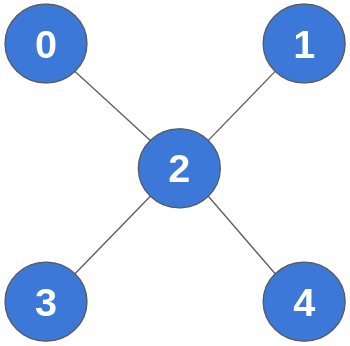


With native gates:

> Our chip has two native gates, Drags and CZs. In addition, it supports all gates that have the qasm_label property in Qibo.

Question: Drag = Derivative Removal by Adiabatic Gate (DRAG) pulse envelope? Not familiar with that gate

### Performance tests

Here we put some tests to determine what is the most adequate configuration for optimal speed. The most straighforward backends Qibo offers are a `numpy` (simple, comes default) and `qibojit` (needs to be installed). In principle, `qibojit` should be more optimized, but it performs threaded caclulations which may cause an overhead slowdown for small circuit sizes. This is made sure next, qibojit allows to delve into higher qubit numbers:

In [4]:
def test_backend(test):
    # Runs test() first on qibojit backend and then on numpy backend to compare.
    qibo.set_backend("qibojit")
    print(" - qibojit backend test")
    test()
    print("\n\n")
    qibo.set_backend("numpy")
    print(" - numpy backend test")
    test()

def scaling(func, interval, exponential=False):
    # Computes and plots the timescaling O(N) of a function with one free parameter: f(N)
    # we can't plot inline for some reason ... :(. If using windows or other os, change macosx
    t_list = np.empty((len(interval),)) # by default float32
    for i, x in enumerate(interval):
        t = %timeit -o -r 3 func(x)
        t_list[i] = t.average

    if not(exponential): m, b = np.polyfit(np.log(interval), np.log(t_list), 1)
    else: m, b = np.polyfit(interval, np.log(t_list), 1)
    
    plt.plot(interval, t_list)
    plt.xlabel('N')
    plt.ylabel('T (s)')
    if not(exponential): 
        plt.loglog()
        plt.plot([interval[0], interval[-1]], [np.exp(np.log(interval[0])*m + b), np.exp(np.log(interval[-1])*m + b)], '--', label=f"{np.exp(b):.3e} · N^{m:.3f}")
    else: 
        plt.yscale('log')
        plt.plot([interval[0], interval[-1]], [np.exp(interval[0]*m + b), np.exp(interval[-1]*m + b)], '--', label=f"{np.exp(b):.3e} · exp(N^{m:.3f})")
    plt.legend()
    plt.show()

In [48]:
def quadratic(n):
    for i in range(n):
        for j in range(i, n):
            pass

interval = 3**np.arange(3,10)

scaling(quadratic, interval)

9.17 μs ± 24.7 ns per loop (mean ± std. dev. of 3 runs, 100,000 loops each)
51.7 μs ± 1.54 μs per loop (mean ± std. dev. of 3 runs, 10,000 loops each)
365 μs ± 1.29 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
5.79 ms ± 114 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
54.1 ms ± 1.16 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
478 ms ± 8.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4.26 s ± 9.83 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [49]:
Nrange = [5, 10, 12, 14]

def QFTtest():
    from qibo.models import QFT
    for N in Nrange:
        print(f"Run {N:2d} qubit QFT circuit")
        %timeit -r 3 QFT(5)()

def simplecirctest_(N, layers=20):
    from qibo import Circuit
    from qibo.gates import H, CZ, T
    circ = Circuit(N)
    for q in range(N):
        circ.add(H(q))

    for l in range(layers):
        for q in range(N):
            circ.add(T(q))
        for q in range(N):
            circ.add(CZ(q,(q+1)%N))
    return circ

def simplecirctest():
    for N in Nrange:
        print(f"Run {N:2d} qubit simple circuit")
        %timeit -r 3 simplecirctest_(N)()

def randomcirctest_(N, layers=20):
    from qibo import Circuit
    from qibo.gates import H, CZ, RX, RZZ
    from numpy.random import random
    circ = Circuit(N)
    for q in range(N):
        circ.add(H(q))

    for l in range(layers):
        for q in range(N):
            circ.add(RX(q, random()))
        for q in range(N):
            circ.add(RZZ(q,(q+1)%N, random()))
    return circ

def randomcirctest():
    for N in Nrange:
        print("Run {:2d} qubit random circuit".format(N))
        %timeit -r 3 randomcirctest_(N)()

def randomcircmeasurement_(N):
    from qibo.symbols import X, Y, Z, I
    from qibo.hamiltonians import SymbolicHamiltonian
    h = X(0)
    for q in range(1,N):
        h += X(q) + Z(q-1)*Z(q)
    h = SymbolicHamiltonian(h)

    h.expectation(randomcirctest_(N)().state())

def randomcircmeasurement():
    for N in Nrange:
        print("Run {:2d} qubit expectation of random circuit".format(N))
        %timeit -r 3 randomcircmeasurement_(N)

In [52]:
ninterval = [5,6,7,8,9,10,11,12,13,14,15]

plt.title('Random circuit + measurement : qibojit vs numpy')

qibo.set_backend("numpy")
scaling(randomcircmeasurement_, ninterval, exponential=True)

qibo.set_backend("qibojit")
scaling(randomcircmeasurement_, ninterval, exponential=True)

[Qibo 0.2.16|INFO|2025-04-25 14:43:41]: Using numpy backend on /CPU:0


9.45 ms ± 300 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
11.7 ms ± 11.9 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
14.1 ms ± 17.6 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
17.7 ms ± 32.1 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
22.6 ms ± 129 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
31 ms ± 33.5 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
47.5 ms ± 901 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
73.1 ms ± 251 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
124 ms ± 1.15 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
226 ms ± 907 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)


[Qibo 0.2.16|INFO|2025-04-25 14:44:18]: Using qibojit (numba) backend on /CPU:0


438 ms ± 9.28 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
18.3 ms ± 18.4 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
25 ms ± 3.5 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
26.3 ms ± 162 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
39.7 ms ± 5.24 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
38.4 ms ± 2.68 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
41.6 ms ± 259 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
49.5 ms ± 2.34 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
55.1 ms ± 4.33 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
64.3 ms ± 3.01 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
76.6 ms ± 1.96 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
105 ms ± 7.88 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


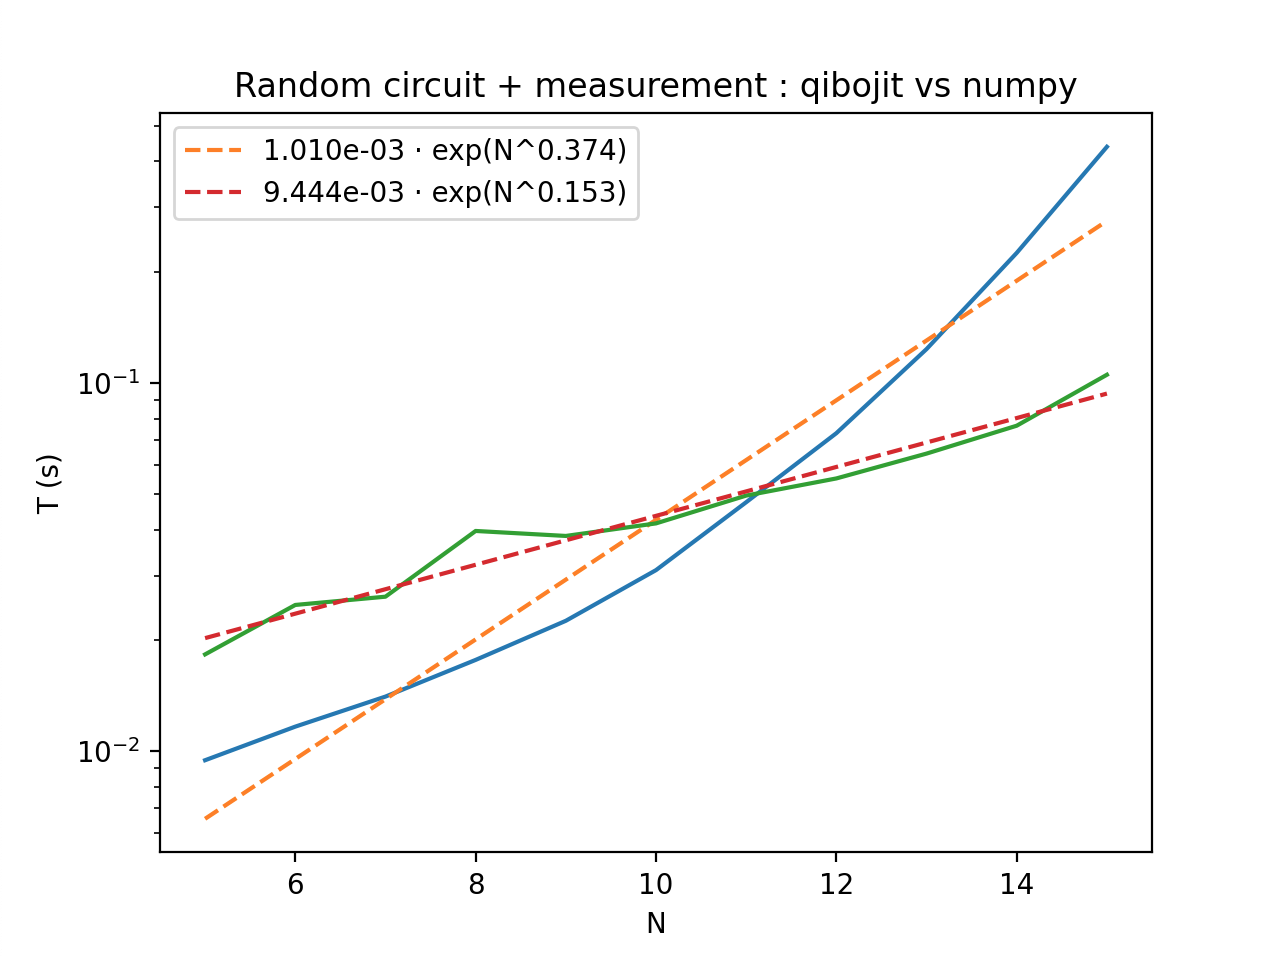

In blue numpy backend, in green qibojit backend. We can observe the qibojit backend has more overhead, a higher constant factor, but scales much slower which allows for treating more qubits. 

In [23]:
test_backend(simplecirctest)

[Qibo 0.2.16|INFO|2025-04-08 15:37:40]: Using qibojit (numba) backend on /CPU:0


 - qibojit backend test
Run  5 qubit simple circuit
12.2 ms ± 355 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Run 10 qubit simple circuit
25.7 ms ± 430 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Run 15 qubit simple circuit
59.9 ms ± 4.89 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Run 20 qubit simple circuit


[Qibo 0.2.16|INFO|2025-04-08 15:37:52]: Using numpy backend on /CPU:0


694 ms ± 8.37 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)



 - numpy backend test
Run  5 qubit simple circuit
4.67 ms ± 161 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Run 10 qubit simple circuit
19.6 ms ± 344 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Run 15 qubit simple circuit
386 ms ± 611 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Run 20 qubit simple circuit
15.8 s ± 365 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [24]:
test_backend(QFTtest)

[Qibo 0.2.16|INFO|2025-04-08 15:39:07]: Using qibojit (numba) backend on /CPU:0


 - qibojit backend test
Run  5 qubit QFT circuit
1.35 ms ± 114 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
Run 10 qubit QFT circuit
1.32 ms ± 66.7 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
Run 15 qubit QFT circuit
1.89 ms ± 367 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Run 20 qubit QFT circuit


[Qibo 0.2.16|INFO|2025-04-08 15:39:24]: Using numpy backend on /CPU:0


1.34 ms ± 40.2 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)



 - numpy backend test
Run  5 qubit QFT circuit
729 μs ± 16.1 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
Run 10 qubit QFT circuit
723 μs ± 26.7 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
Run 15 qubit QFT circuit
708 μs ± 4.7 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
Run 20 qubit QFT circuit
718 μs ± 10.7 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)


In [25]:
test_backend(randomcirctest)

[Qibo 0.2.16|INFO|2025-04-08 15:39:36]: Using qibojit (numba) backend on /CPU:0


 - qibojit backend test
Run  5 qubit random circuit
21.2 ms ± 3.44 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Run 10 qubit random circuit
40.2 ms ± 729 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Run 15 qubit random circuit
85.4 ms ± 794 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
Run 20 qubit random circuit


[Qibo 0.2.16|INFO|2025-04-08 15:39:48]: Using numpy backend on /CPU:0


1.54 s ± 128 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)



 - numpy backend test
Run  5 qubit random circuit
9.59 ms ± 481 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Run 10 qubit random circuit
31.5 ms ± 1.41 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Run 15 qubit random circuit
437 ms ± 21.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Run 20 qubit random circuit
15.7 s ± 140 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [28]:
test_backend(randomcircmeasurement)

[Qibo 0.2.16|INFO|2025-04-08 16:25:54]: Using qibojit (numba) backend on /CPU:0


 - qibojit backend test
Run  5 qubit expectation of random circuit
358 ms ± 36.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Run 10 qubit expectation of random circuit
793 ms ± 173 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Run 15 qubit expectation of random circuit
2.41 s ± 67.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Run 20 qubit expectation of random circuit


[Qibo 0.2.16|INFO|2025-04-08 16:30:54]: Using numpy backend on /CPU:0


1min 13s ± 2.69 s per loop (mean ± std. dev. of 3 runs, 1 loop each)



 - numpy backend test
Run  5 qubit expectation of random circuit
71.8 ms ± 2.66 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Run 10 qubit expectation of random circuit
496 ms ± 171 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Run 15 qubit expectation of random circuit
11.2 s ± 22 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Run 20 qubit expectation of random circuit


KeyboardInterrupt: 

In [96]:
# Conclusion, we might as well use just qibojit as intended.
# For some cases with n <= 10, we could arguably use numpy for a small speed up boost.
# This was more significant when running simulations on computer, but not on cluster.

### Qibo Basics

We copy here some basic instructions for reference https://qibo.science/qibo/stable/code-examples/examples.html.

#### Circuits and gates


Circuits are the main building blocks, as it is Quantum Circuits that will perform many calculations

In [218]:
import numpy as np
from qibo import Circuit, gates

"""# SET PRECISION
qibo.set_precision("single") # enables complex64
# or
qibo.set_precision("double") # re-enables complex128"""

# Construct the circuit : 2 qubits
circuit = Circuit(2)
# Add some gates
circuit.add(gates.H(0)); circuit.add(gates.H(1))
# Define an initial state (optional - default initial state is |00>)
initial_state = np.ones(4) / 2.0
# Execute the circuit and obtain the final state
result = circuit(initial_state) # circuit.execute(initial_state) also works
print(result.state())
# should print `np.array([1, 0, 0, 0])

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


#### Gates

Qibo does not support the implementation of arbitrary gates from their matrix representation, as the gates it does employ are optimized. But that is not a problem as the circuits that we build must be implementable, if they are to be useful. That means everything must be decomposed in some set of fundamental gates. 

We don't consider now a full decomposition into a basic hardware specific set of gates, but as usual on some set of simple: one qubit rotations and two qubit gates.

`RX, RY, RZ, X, Y, Z, H, T, CNOT, CZ, RZZ`

#### Draw circuit

In [59]:
import matplotlib.pyplot as plt
import qibo
from qibo import gates, models
from qibo.models import QFT

# new plot function based on matplotlib
from qibo.ui import plot_circuit

# create a 5-qubits QFT circuit
circuit = QFT(5)
circuit.add(gates.M(qubit) for qubit in range(2))

### PRETTY DRAW
# print circuit with default options (default black & white style, scale factor of 0.6 and clustered gates)
### plot_circuit(circuit)  ### Can't plot, crashes

### Unicode print:
circuit.draw()

0: ─H─U1─U1─U1─U1───────────────────────────x───M─
1: ───o──|──|──|──H─U1─U1─U1────────────────|─x─M─
2: ──────o──|──|────o──|──|──H─U1─U1────────|─|───
3: ─────────o──|───────o──|────o──|──H─U1───|─x───
4: ────────────o──────────o───────o────o──H─x─────


In [65]:
# CAREFUL WITH MATPLOTLIB
plot_circuit(circuit, style='quantumspain')

(<Axes: >, <Figure size 2160x600 with 1 Axes>)

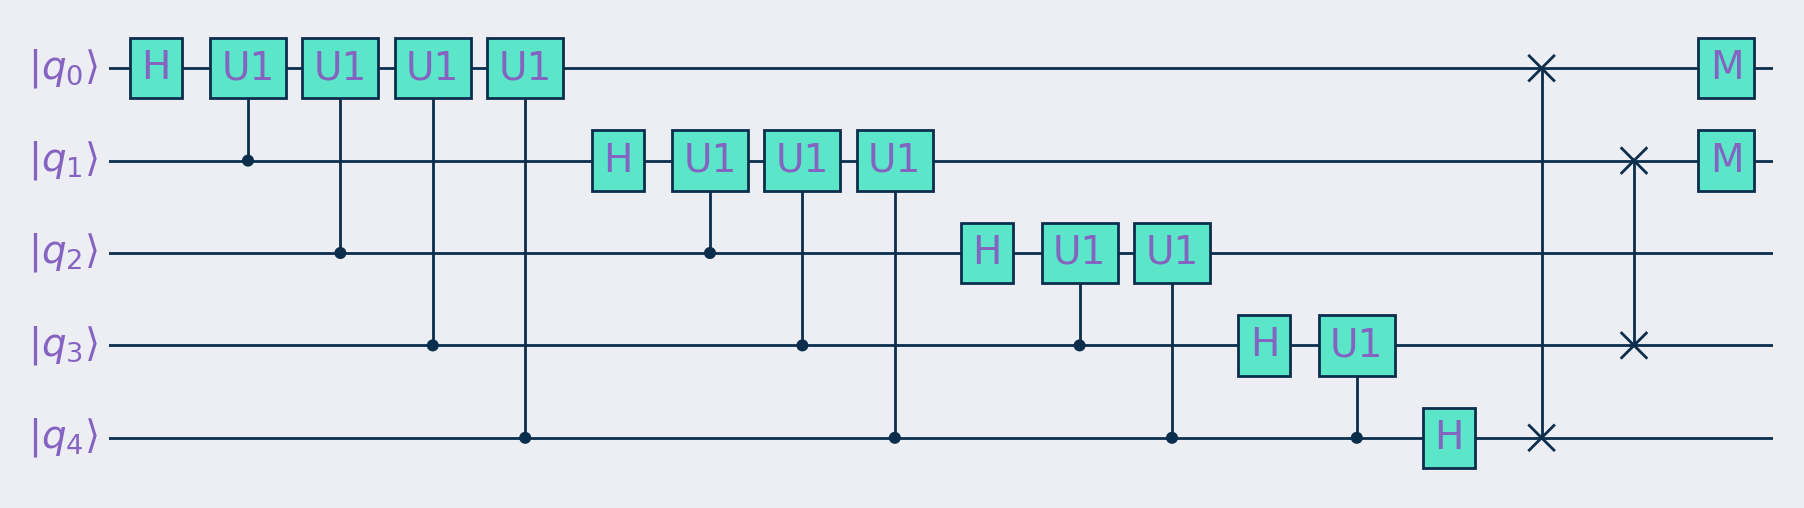

#### Parametrized Circuits

Just as some gates were discussed earlier, some gates allow parameters.

Once a circuit has been parametrized, its parameters can be changed using: `circuit.set_parameters()`.

Likewise, they can be obtained by using `circuit.get_parameters()`.

A parametrized gate can be exluded from this interaction by setting `trainable=False`.


The parameters, to be set or get, can be represented as a list of values (in order of applied gates) or as a dictionary with gates as the key.

In [67]:
# now we make a variational circuit

N = 5
p = N//2
circuit = Circuit(N)
params = np.random.random((2*N*p,))*0

for q in range(N):
    circuit.add(gates.H(q))
for itp in range(p):
    for itzz in range(N):
        circuit.add(gates.RZZ(itzz, (itzz+1)%N, params[2*N*itp + itzz]))
    for itx in range(N):
        circuit.add(gates.RX(itx, params[2*N*itp + N + itx]))
circuit.draw()


0: ─H─RZZ─────────────RZZ─RX─RZZ─────────────RZZ─RX─
1: ─H─RZZ─RZZ─────────|───RX─RZZ─RZZ─────────|───RX─
2: ─H─────RZZ─RZZ─────|───RX─────RZZ─RZZ─────|───RX─
3: ─H─────────RZZ─RZZ─|───RX─────────RZZ─RZZ─|───RX─
4: ─H─────────────RZZ─RZZ─RX─────────────RZZ─RZZ─RX─


### Observables

To calculate expectation values. Again, in line with the optimization ideas of qibo, we don't want to get bottlenecked by writing out (2^n)^2 matrices. So we use scipy sparse matrices to define qibo.hamiltonian objects.

Qibo `qibo.hamiltoninans.X(nqubits)` are equivalent to $\sum_i X_i$

Symbolic operators/Hamiltonians can be created using qibo.symbols.

The problem is that to compute ground_states and energies with the built in methods, matrices are by default converted to dense form, so it is not very practical.

In [4]:
from qibo.symbols import X, Y, Z, I
ham = I(3)*0

N = 10
g = 10
circuit = Circuit(N)

for q in range(N):
    circuit.add(gates.H(q))

# Transverse field ising hamiltonian built using symbols
for q in range(N):
    ham += Z(q)*Z((q+1)%5) + g * X(q)
Ham = qibo.hamiltonians.SymbolicHamiltonian(-ham,)

# We compute the expected energy value of the |++...++> state
print("<psi|H|psi> = ",Ham.expectation(circuit().state()))


# We print the numerical "exact" energies
Ham.eigenvalues(1)



[Qibo 0.2.16|WARNING|2025-08-20 01:37:48]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


<psi|H|psi> =  -99.99999999999983


array([-100.25034155,  -82.67448456,  -81.53299407, ...,   82.3203459 ,
         82.3203459 ,  100.25028639])

### Example from Qibo: How to perform a custom variational circuit optimization?

In this example, a circuit is trained to produce a desired state. Fidelity is used, which is not an easily physically accessible measurement.

In [22]:
import numpy as np

from qibo import Circuit, gates
from qibo.optimizers import optimize
from qibo.quantum_info import infidelity

qibo.set_backend("numpy")

# custom loss function, computes fidelity
def myloss(parameters, circuit, target):
    circuit.set_parameters(parameters)
    final_state = circuit().state()
    return infidelity(final_state, target)

nqubits = 8
dims = 2**nqubits
nlayers  = 2

# Create variational circuit
circuit = Circuit(nqubits)
for l in range(nlayers):
    circuit.add(gates.RY(qubit, theta=0.0) for qubit in range(nqubits))
    circuit.add(gates.CZ(qubit, qubit + 1) for qubit in range(0, nqubits - 1, 2))
    circuit.add(gates.RY(qubit, theta=0.0) for qubit in range(nqubits))
    circuit.add(gates.CZ(qubit, qubit + 1) for qubit in range(1, nqubits - 2, 2))
    circuit.add(gates.CZ(0, nqubits - 1))
circuit.add(gates.RY(qubit, theta=0.0) for qubit in range(nqubits))

# Optimize starting from a random guess for the variational parameters
x0 = np.random.uniform(0, 2 * np.pi, nqubits * (2 * nlayers + 1))
data = np.random.normal(0, 1, size=dims)

data /= np.sqrt(np.sum(np.abs(data)**2))

# perform optimization
print("Optimizing")
best, params, extra = optimize(myloss, x0, args=(circuit, data), method='BFGS')

# set final solution to circuit instance
circuit.set_parameters(params)


[Qibo 0.2.16|INFO|2025-04-03 10:24:36]: Using numpy backend on /CPU:0


Optimizing


In [49]:
# We can see the circuit has been trained to output a state very similar to the desired one

print(circuit().state())

print(data)

best

[-6.47236633e-02+0.j  4.71552313e-02+0.j  7.00581202e-02+0.j
  2.25255143e-01+0.j  1.34002740e-01+0.j -1.43226412e-02+0.j
  1.92136574e-01+0.j -1.11880410e-01+0.j  6.28977488e-02-0.j
 -1.80230975e-01+0.j -1.66127505e-01+0.j  4.64383987e-02+0.j
 -1.36533276e-03+0.j  4.23468666e-02+0.j -1.25572929e-02-0.j
 -1.91270999e-02+0.j  4.62615035e-02+0.j  9.16535759e-02+0.j
 -3.98690419e-02+0.j  3.23276481e-03+0.j -1.71288315e-01+0.j
 -5.25504201e-02+0.j -1.08399885e-01+0.j -3.31147092e-04+0.j
  9.14041345e-02+0.j  5.25239215e-03+0.j -1.76869543e-02+0.j
  1.55446945e-01+0.j  1.75839149e-01+0.j -7.23824544e-02+0.j
 -5.48281243e-02-0.j -1.80002976e-01+0.j  6.27247890e-02+0.j
  2.19268210e-02+0.j -7.61663641e-02-0.j -2.54208946e-01+0.j
 -6.56853581e-02+0.j  7.28971541e-02+0.j -5.46210773e-02-0.j
 -9.65811384e-02+0.j  2.93922597e-01+0.j  2.19358288e-01+0.j
 -3.45525546e-01+0.j -6.24820072e-02+0.j -1.37433236e-01+0.j
 -1.84916075e-01+0.j  1.45933499e-01+0.j -4.95144679e-02+0.j
 -1.33184611e-01+0.j -1.

1.8826626146939418e-07

### Parameter shift rule

To compute gradients, we invoke the parameter shift rule, which is an implementable method to calculate gradients without requiring knowledge about the state vector and which is exact as opposed to a finite differences method. For some parameter particular $\theta_k$ such that it parametrizes a single gate of the form $U_k(\theta_k) = e^{i\theta_k G}$, with G for instance a pauli string, then it holds that:

$$\frac{\partial f}{\partial \theta_k} = r\bigg[ f(\theta_k + s_k)-f(\theta_k - s_k)\bigg ]$$

To compute more complicated expressions some other combinations hold or other methods can be combined with like the chain rule.

For instance, in translationally equivariant circuits, a single parameter will not only affect a single unitary acting on a single qubit, but rather it will affect many different gates at once!
This requires more careful consideration and implementation. But by the chain rule, the derivative can be expressed as the sum of the individual derivatives with respect to the single individual unitaries, so just a sum of the different parameter shifts for each implemented shared parameter gate.

In [18]:
def parameter_shift(
    circuit,
    hamiltonian,
    parameter_index,
    initial_state=None,
    scale_factor=1,
    nshots=None,
    nruns=1,
    repeated = False
):
    """In this method the parameter shift rule (PSR) is implemented.
    Given a circuit U and an observable H, the PSR allows to calculate the derivative
    of the expected value of H on the final state with respect to a variational
    parameter of the circuit.
    There is also the possibility of setting a scale factor. It is useful when a
    circuit's parameter is obtained by combination of a variational
    parameter and an external object, such as a training variable in a Quantum
    Machine Learning problem. For example, performing a re-uploading strategy
    to embed some data into a circuit, we apply to the quantum state rotations
    whose angles are in the form: theta' = theta * x, where theta is a variational
    parameter and x an input variable. The PSR allows to calculate the derivative
    with respect of theta' but, if we want to optimize a system with respect its
    variational parameters we need to "free" this procedure from the x depencency.
    If the `scale_factor` is not provided, it is set equal to one and doesn't
    affect the calculation.
    Args:
        circuit (:class:`qibo.models.circuit.Circuit`): custom quantum circuit.
        hamiltonian (:class:`qibo.hamiltonians.Hamiltonian`): target observable.
        parameter_index (int): the index which identifies the target parameter in the circuit.get_parameters() list
        initial_state ((2**nqubits) vector): initial state on which the circuit acts (default None).
        scale_factor (float): parameter scale factor (default None).
        repeated (bool): indicates if the gates that use the parameter have a translational symmetry
    Returns:
        np.float value of the derivative of the expectation value of the hamiltonian
        with respect to the target variational parameter.
    Example:
        .. testcode::
            import qibo
            import numpy as np
            from qibo import hamiltonians, gates
            from qibo.models import Circuit
            from qibo.derivative import parameter_shift
            # defining an observable
            def hamiltonian(nqubits = 1):
                m0 = (1/nqubits)*hamiltonians.Z(nqubits).matrix
                ham = hamiltonians.Hamiltonian(nqubits, m0)
                return ham
            # defining a dummy circuit
            def circuit(nqubits = 1):
                c = Circuit(nqubits = 1)
                c.add(gates.RY(q = 0, theta = 0))
                c.add(gates.RX(q = 0, theta = 0))
                c.add(gates.M(0))
                return c
            # initializing the circuit
            c = circuit(nqubits = 1)
            # some parameters
            test_params = np.random.randn(2)
            c.set_parameters(test_params)
            test_hamiltonian = hamiltonian()
            # running the psr with respect to the two parameters
            grad_0 = parameter_shift(circuit = c, hamiltonian = test_hamiltonian, parameter_index = 0)
            grad_1 = parameter_shift(circuit = c, hamiltonian = test_hamiltonian, parameter_index = 1)
    """
    """We modify the Qibo implementation to allow multiple parameter_index. For the case where a parameter is reused in different gates"""
    gradient = 0
    try:
        iter(parameter_index) # check if it is iterable
    except:
        parameter_index = [parameter_index]
    if repeated:
        nparam = len(parameter_index)
        parameter_index = parameter_index[:1]
    for parameter_index in parameter_index:
        # inheriting hamiltonian's backend
        backend = hamiltonian.backend

        # getting the gate's type
        gate = circuit.associate_gates_with_parameters()[parameter_index]

        # getting the generator_eigenvalue
        ###try: generator_eigenval = gate.generator_eigenvalue()
        ###except: 
        #generator_eigenval = 0.5   #### CAN'T DO SOMETHING LIKE THIS... ERROR GETS LOGGED ANYWAYS BY QIBO FUNCTION RAISE_ERROR, EVEN IF CAUGHT BY TRY
        # getting the generator_eigenvalue
        generator_eigenval = gate.generator_eigenvalue()

        # defining the shift according to the psr
        s = np.pi / (4 * generator_eigenval)

        # saving original parameters and making a copy
        original = np.asarray(circuit.get_parameters()).copy()
        shifted = original.copy()

        # forward shift and evaluation
        shifted[parameter_index] += s
        circuit.set_parameters(shifted)

        forward = 0
        backward = 0


        if nshots == None:
            forward = hamiltonian.expectation(
                backend.execute_circuit(circuit=circuit, initial_state=initial_state).state()
            )

            # backward shift and evaluation
            shifted[parameter_index] -= 2 * s
            circuit.set_parameters(shifted)

            backward = hamiltonian.expectation(
                backend.execute_circuit(circuit=circuit, initial_state=initial_state).state()
            )

        else:
            
            copied = shifted.copy()

            for _ in range(nruns):

                forward += np.float64(hamiltonian.expectation_from_circuit(circuit, nshots=nshots).real)
                """backend.execute_circuit(
                    circuit=circuit, 
                    initial_state=initial_state, 
                    nshots=nshots
                    ).expectation_from_samples(hamiltonian)"""

                # backward shift and evaluation
                shifted[parameter_index] -= 2 * s
                circuit.set_parameters(shifted)

                backward += np.float64(hamiltonian.expectation_from_circuit(circuit, nshots=nshots).real)
                """backend.execute_circuit(
                    circuit=circuit, 
                    initial_state=initial_state, 
                    nshots=nshots
                    ).expectation_from_samples(hamiltonian)  """

                # restoring the original circuit
                shifted = copied.copy()
                circuit.set_parameters(copied)

            forward /= nruns
            backward /= nruns
                
        circuit.set_parameters(original)
        
        gradient += generator_eigenval * (forward - backward) * scale_factor

    if repeated: gradient *= nparam
    return gradient

In [19]:
gates.RZ(0, 0.).generator_eigenvalue()

try: gates.RZZ(0, 1, 0.).generator_eigenvalue()
except NotImplementedError: print("Not implemented")

# EVEN IF CAUGHT, GENERATOR EIGENVALUE ERRORS GET LOGGED
# SO WE SHOULD JUST IMPLEMENT GENERATOR EIGENVALUES. IN FACT FOR THE RZZ GATE IT IS ALSO 0.5, EVEN IF IT IS NOT IMPLEMENTED BY DEFAULT IN QIBO

### Example solution: Symmetric Variational Eigensolver

We can consider trying to replicate results from the "Exploiting symmetry in variational quantum machine learning" [https://doi.org/10.1103/PRXQuantum.4.010328] paper.    
We will implement two variational eigensovlers, two parametrized circuits as ansatz for the ground state, with parameters which we will optimize.

#### Transverse field ising model

In [20]:
# Hamiltonian
def hamiltonianTFI(N, g):
    ham = 0*I(0)
    for q in range(N):
        ham += Z(q)*Z((q+1)%N) + g * X(q)
    return qibo.hamiltonians.SymbolicHamiltonian(-ham)

# Hamiltonian
def hamiltonianTFI_open(N, g):
    ham = 0*I(0)
    for q in range(N-1):
        ham += Z(q)*Z(q+1) + g * X(q)
    ham += g * X(N-1)
    return qibo.hamiltonians.SymbolicHamiltonian(-ham)

In [21]:
# Analytical solutions
N = 4
g = 1
ham = hamiltonianTFI(N, g)
eigvec, eigval = ham.eigenvectors(), ham.eigenvalues()

ham_o = hamiltonianTFI_open(N, g)
eigvec_o, eigval_o = ham_o.eigenvectors(), ham_o.eigenvalues()

def prettystate(statevector):
    s = ""
    for i in range(len(statevector)):
        if(np.abs(statevector[i]) > 1e-6):
            b = bin(i+2**N)[3:]
            s += f"({statevector[i]:.5f}) |{b}> + "
    return s

print(prettystate(eigvec[:,0]))
print(prettystate(eigvec_o[:,0]))
print(eigval[0])

[Qibo 0.2.16|WARNING|2025-08-22 05:51:12]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.16|WARNING|2025-08-22 05:51:12]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


(0.57664+0.00000j) |0000> + (0.17678+0.00000j) |0001> + (0.17678+0.00000j) |0010> + (0.13530+0.00000j) |0011> + (0.17678+0.00000j) |0100> + (0.07664+0.00000j) |0101> + (0.13530+0.00000j) |0110> + (0.17678+0.00000j) |0111> + (0.17678+0.00000j) |1000> + (0.13530+0.00000j) |1001> + (0.07664+0.00000j) |1010> + (0.17678+0.00000j) |1011> + (0.13530+0.00000j) |1100> + (0.17678+0.00000j) |1101> + (0.17678+0.00000j) |1110> + (0.57664+0.00000j) |1111> + 
(-0.47990+0.00000j) |0000> + (-0.25535+0.00000j) |0001> + (-0.16667+0.00000j) |0010> + (-0.22455+0.00000j) |0011> + (-0.16667+0.00000j) |0100> + (-0.10878+0.00000j) |0101> + (-0.14656+0.00000j) |0110> + (-0.25535+0.00000j) |0111> + (-0.25535+0.00000j) |1000> + (-0.14656+0.00000j) |1001> + (-0.10878+0.00000j) |1010> + (-0.16667+0.00000j) |1011> + (-0.22455+0.00000j) |1100> + (-0.16667+0.00000j) |1101> + (-0.25535+0.00000j) |1110> + (-0.47990+0.00000j) |1111> + 
-5.226251859505507


$$H_\text{TFIM} = - \sum_{i = 1}^N Z_i Z_{i+1} + gX_i$$

For this hamiltonian, we focus on the spin flip symmetry it has. If we perform a bit flip in all states, the energy remains the same. In other words, the implicit symmetry is a $\mathbb{Z}_2$ symmetry, corresponding to this single idempotent parity operator:
$$P = \prod_{i=1}^N X_i$$
As a reminder, the standard way to express $\mathbb{Z}_2$ is as 0 and 1 modulo 2:  1+1 = 0, 0+x = x.

So the representation of $s \in G = \mathbb{Z}_2$ is $P^s $.

Furthermore, as it commutes, the ground state will also be an eigenvalue of this parity operator. This imposes a limitation, our strategy will be to make our ansatz also respect this symmetry, but for this then we must already start with an eigenstate of the parity operator with same eigenvalue as the ground state. This analysis is conducted very cleanly in the paper: For $g\to \infty$ the ground state is $\ket{+}^{\otimes N}$ which has parity +1. By the adiabatic theorem and the fact that for finite system size the ground state energy is not degenerate, the parity of the ground state must also remain +1 by continuity. This may only hold up to the phase transition at $g=0$, as there this assumption is broken.


The equivariant circuit/ansatz taken is the following:
$$\prod_{m=1}^p \prod_{i=1}^N e^{-i\beta_m X_i}\prod_{i=1}^N e^{-i\gamma_m Z_iZ_{i+1}}$$

And we consider a non equivariant one as an extension of this one:

$$\prod_{m=1}^p \prod_{i=1}^N e^{-i\alpha_m Y_i} \prod_{i=1}^N e^{-i\beta_m X_i}\prod_{i=1}^N e^{-i\gamma_m Z_iZ_{i+1}}$$

The optimization procedure outlined in the reference is as follows:

With $N=10$, the two ansatz are optimized using L-BFGS optimizer until convergence is reached (criterion for convergence is not specified).
The optimization is performed for 20 different random initializations of the parameters.


But actually... the initial implementation to be found here is different, as it focuses **only** on the implementation of the parity symmetry. The ansatz is: 

$$\prod_{m=1}^p \prod_{i=1}^N e^{-i\beta_{m,i} X_i}\prod_{i=1}^N e^{-i\gamma_{m,i} Z_iZ_{i+1}}$$

On a same layer, the coefficients are not the same for different qubits. If it is the case, as happens in the reference paper, then translation symmetry of the problem is also being considered!

What follows is the non transverse implementation. As a reminder, the ZZ gates may seem artificial and not hardware friendly, but in fact any pauli string rotation can be implemented with just the $R_Z$ gate and $CNOT$ gates, if we can perform necessary changi e of basis between $X, Y, Z$ using the $H$ and $S$ gates.

$e^{-i \theta P}$, with $P$ a generic pauli string, means just that in the diagonal to $P$ basis we perform a phase change only determined by parity, ammount of qubits in the -1 eigenvector state. So  this is the same as just adding this parity by performing CNOTs towards a single qubit and then applying the RZ in that qubit.

#### Non translational invariant

In [22]:
#import sys
#sys.path.append('../modules/'
# Parmaterized Circuit: Invariant

qibo.gates.RZZ.generator_eigenvalue = lambda self: 0.5
def circ_inv(N, p):
    # Structure of the invariant circuit 
    params = np.random.random((2*N*p,))*4*np.pi
    circuit_inv = Circuit(N)
    for q in range(N):
        circuit_inv.add(gates.H(q))  # WE START WITH |+> state
    for itp in range(p):
        for itzz in range(N):
            circuit_inv.add(gates.RZZ(itzz, (itzz+1)%N, params[2*N*itp + itzz]))
        for itx in range(N):
            circuit_inv.add(gates.RX(itx, params[2*N*itp + N + itx]))
    return circuit_inv, params

def circ_noinv(N, p):
    # Structure of the non-invariant circuit (with added Y gates)
    params2 = np.random.random((3*N*p,))*4*np.pi
    circuit_noinv = Circuit(N)
    for q in range(N):
        circuit_noinv.add(gates.H(q))
    for itp in range(p):
        for itzz in range(N):
            circuit_noinv.add(gates.RZZ(itzz, (itzz+1)%N, params2[3*N*itp + itzz]))
        for itx in range(N):
            circuit_noinv.add(gates.RX(itx, params2[3*N*itp + N + itx]))
        for ity in range(N):
            circuit_noinv.add(gates.RY(ity, params2[3*N*itp + 2*N + ity]))
    return circuit_noinv, params2


def circs(N, p, g = 1, custom_operator=None):
    if custom_operator is None: 
        hamiltonian = hamiltonianTFI(N, g)
    else:
        hamiltonian = custom_operator
    
    circuit_inv, params = circ_inv(N,p)
    circuit_noinv, params2 = circ_noinv(N,p)

    def loss(params):
        circuit_inv.set_parameters(params)
        return hamiltonian.expectation(circuit_inv().state())

    def loss2(params):
        circuit_noinv.set_parameters(params)
        return hamiltonian.expectation(circuit_noinv().state())

    return circuit_inv, circuit_noinv, params, params2, loss, loss2

In [79]:
plot_circuit(circ_inv(6,3)[0], scale = 0.6, cluster_gates = True, style="quantumspain")

(<Axes: >, <Figure size 2640x718 with 1 Axes>)

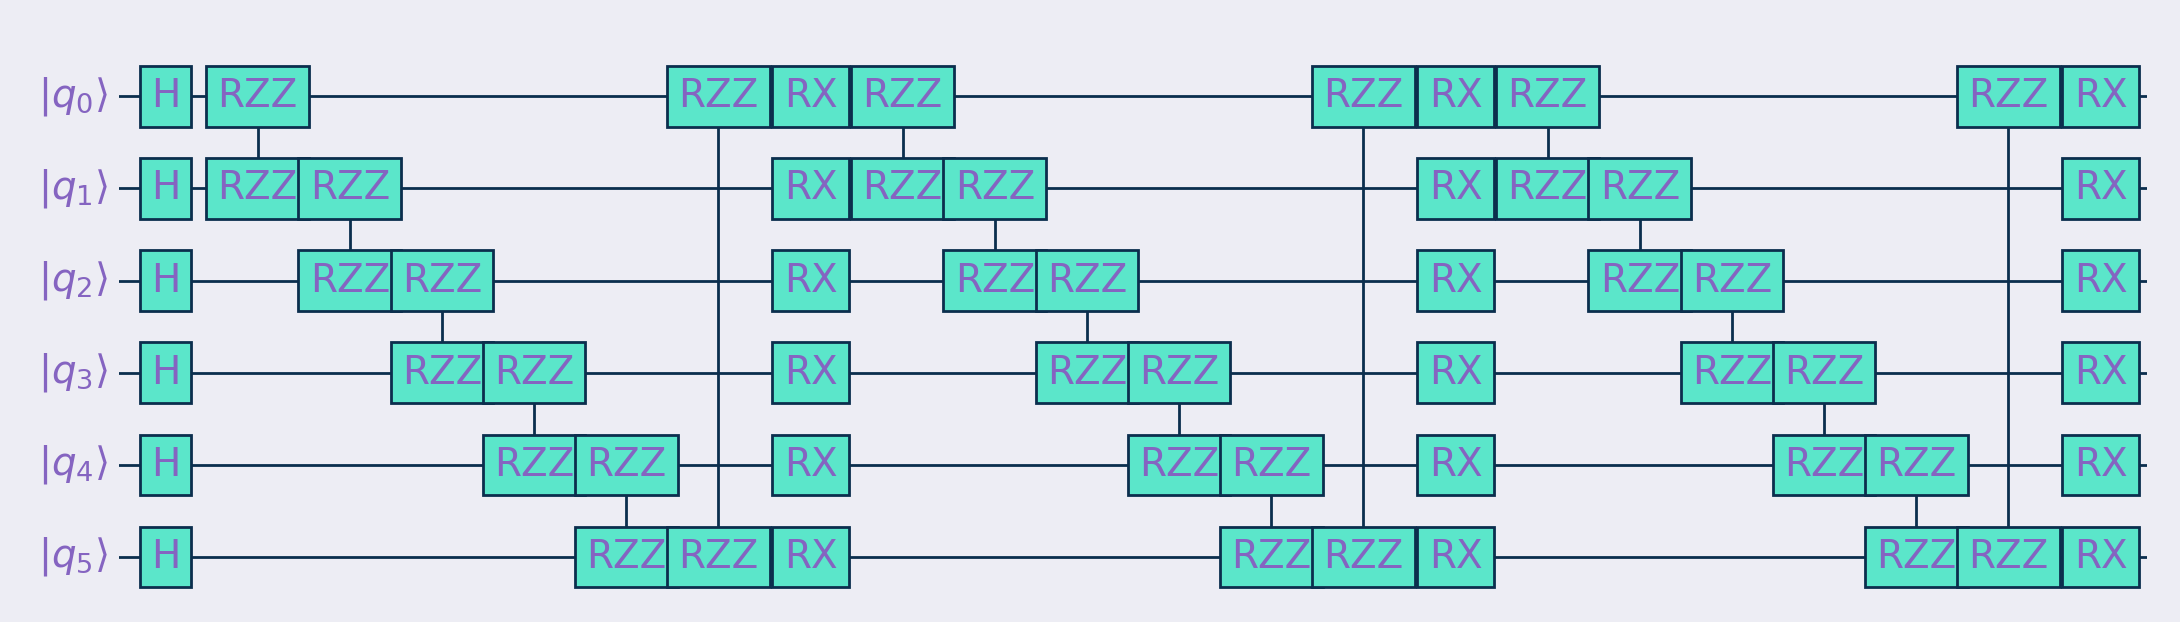



We implement some python functions to compare numerically the invariance is indeed respected by our circuit

In [9]:
def assert_invariance(encoding, circuit, hamiltonian, op_circ):
    print(hamiltonian.expectation(circuit(encoding().state()).state()))
    print(hamiltonian.expectation(op_circ(circuit(encoding().state()).state()).state()))
    print(hamiltonian.expectation(circuit(op_circ(encoding().state()).state()).state()))

from qibo import Circuit

N = 10
p = 5
g = 1
op_circ = Circuit(N)
op_circ.add([gates.X(i) for i in range(N)])

circuit_inv = Circuit(N)
params = np.random.random((2*N*p,))*np.pi
for itp in range(p):
    for itzz in range(N):
        circuit_inv.add(gates.RZZ(itzz, (itzz+1)%N, params[2*N*itp + itzz]))
    for itx in range(N):
        circuit_inv.add(gates.RX(itx, params[2*N*itp + N + itx]))

circ_encoding = Circuit(N)
for q in range(N):
    circ_encoding.add(gates.H(q))

hamiltonian = hamiltonianTFI(N, g)


print("They should be equal if invariance is respected")
assert_invariance(circ_encoding, circuit_inv, hamiltonian, op_circ)


They should be equal if invariance is respected
-1.3797255857435573
-1.3797255857435573
-1.3797255857435573


Now here we can optimize the parameters to approximate and try finding ground state 

In [40]:
## Problem 4

# now we make a variational circuit

N = 6
p = 4
g = 1



hamiltonian = hamiltonianTFI(N, g)

ground_energy = hamiltonian.eigenvalues(1)[0]

print("Exact Ground State: ", ground_energy)



plist = np.array([2,4,6,8,10,12])

rep = 5

Elist_inv = np.empty((7, rep))
Nlist_inv = np.empty((7, rep))
Elist_noinv = np.empty((7, rep))
Nlist_noinv = np.empty((7, rep))


for itp in range(len(plist[:])):
    circuit_inv, circuit_noinv, params, params2, loss, loss2 = circs(N, plist[itp])
    for itt in range(rep):
        print("P: ", itp, ",rep", itt)
        params = np.random.random((2*N*plist[itp],))*np.pi
        params2 = np.random.random((3*N*plist[itp],))*np.pi
        minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")
        Elist_inv[itp,itt] = minE
        Nlist_inv[itp,itt] = scipyRes.nit

        minE, minParams, scipyRes = qibo.optimizers.optimize(loss2, params2, method = "BFGS")
        Elist_noinv[itp,itt] = minE
        Nlist_noinv[itp,itt] = scipyRes.nit

#minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")
        
print(Elist_inv)
print()
print(Nlist_inv)
print()
print(Elist_noinv)
print()
print(Nlist_noinv)


[Qibo 0.2.16|WARNING|2025-08-22 06:51:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Exact Ground State:  -7.72740661031255
P:  0 ,rep 0
P:  0 ,rep 1
P:  0 ,rep 2
P:  0 ,rep 3
P:  0 ,rep 4
P:  1 ,rep 0
P:  1 ,rep 1
P:  1 ,rep 2
P:  1 ,rep 3
P:  1 ,rep 4
P:  2 ,rep 0
P:  2 ,rep 1
P:  2 ,rep 2
P:  2 ,rep 3
P:  2 ,rep 4
P:  3 ,rep 0
P:  3 ,rep 1
P:  3 ,rep 2
P:  3 ,rep 3
P:  3 ,rep 4
P:  4 ,rep 0
P:  4 ,rep 1
P:  4 ,rep 2
P:  4 ,rep 3
P:  4 ,rep 4
P:  5 ,rep 0
P:  5 ,rep 1
P:  5 ,rep 2
P:  5 ,rep 3
P:  5 ,rep 4
[[-7.46410162e+000 -7.46410162e+000 -7.46410162e+000 -7.46410162e+000
  -7.46410162e+000]
 [-7.72740661e+000 -7.72740661e+000 -7.72740661e+000 -7.72740661e+000
  -7.72740661e+000]
 [-7.72740661e+000 -7.72740661e+000 -7.72740661e+000 -7.72740661e+000
  -7.72740661e+000]
 [-7.72740661e+000 -7.72740661e+000 -7.72740661e+000 -7.72740661e+000
  -7.72740661e+000]
 [-7.72740661e+000 -7.72740661e+000 -7.72740661e+000 -7.72740661e+000
  -7.72740661e+000]
 [-7.72740661e+000 -7.72740661e+000 -7.72740661e+000 -7.72740661e+000
  -7.72740661e+000]
 [-5.02815865e+263  2.54826504e

In [66]:
print(Elist_inv)
print()
print(Nlist_inv)
print()
print(Elist_noinv)
print()
print(Nlist_noinv)

plist = np.array([2,4,6,8,10,12])

rep = 5

[[-1.24401694e+01 -1.24401694e+01 -1.24401694e+01 -1.24401694e+01
  -1.24401694e+01]
 [-1.26274935e+01 -1.26275010e+01 -1.26232699e+01 -1.26270776e+01
  -1.26275030e+01]
 [-1.27849060e+01 -1.27849063e+01 -1.27849052e+01 -1.27849064e+01
  -1.27849064e+01]
 [-1.27849061e+01 -1.27849063e+01 -1.27849062e+01 -1.27849062e+01
  -1.27849060e+01]
 [-1.27849064e+01 -1.27849064e+01 -1.27849064e+01 -1.27849064e+01
  -1.27849064e+01]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  1.73059648e-77
   5.60230188e-67]]

[[7.90000000e+001 8.60000000e+001 1.52000000e+002 7.70000000e+001
  6.60000000e+001]
 [3.70200000e+003 2.74200000e+003 1.73800000e+003 1.97800000e+003
  3.05000000e+002]
 [4.30000000e+002 5.20000000e+002 5.66000000e+002 7.05000000e+002
  2.79000000e+002]
 [5.33000000e+002 2.49000000e+002 3.89000000e+002 3.02000000e+002
  3.48000000e+002]
 [2.16000000e+002 1.51000000e+002 1.03000000e+002 1.66000000e+0

In [73]:
Elist_inv = np.array([[-1.24401694e+01, -1.24401694e+01, -1.24401694e+01, -1.24401694e+01, -1.24401694e+01],\
 [-1.26274935e+01, -1.26275010e+01, -1.26232699e+01, -1.26270776e+01,\
  -1.26275030e+01],\
 [-1.27849060e+01, -1.27849063e+01, -1.27849052e+01, -1.27849064e+01,\
  -1.27849064e+01],\
 [-1.27849061e+01, -1.27849063e+01, -1.27849062e+01, -1.27849062e+01,\
  -1.27849060e+01],\
 [-1.27849064e+01, -1.27849064e+01, -1.27849064e+01, -1.27849064e+01,\
  -1.27849064e+01],\
 [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,\
   0.00000000e+00],\
 [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00 , 1.73059648e-77,\
   5.60230188e-67]])[:5]

Nlist_inv = np.array([[7.90000000e+001, 8.60000000e+001, 1.52000000e+002, 7.70000000e+001, 6.60000000e+001],
 [3.70200000e+003, 2.74200000e+003, 1.73800000e+003, 1.97800000e+003,
  3.05000000e+002],
 [4.30000000e+002, 5.20000000e+002, 5.66000000e+002, 7.05000000e+002,
  2.79000000e+002],
 [5.33000000e+002, 2.49000000e+002, 3.89000000e+002, 3.02000000e+002,
  3.48000000e+002],
 [2.16000000e+002, 1.51000000e+002, 1.03000000e+002, 1.66000000e+002,
  1.19000000e+002],
 [3.12151705e-033, 1.47762365e+248, 1.16096346e-028, 1.85325047e-051,
  5.45102702e-090],
 [2.21636052e+160, 4.27713137e-037, 4.30423766e-096, 4.82337433e+228,
  5.60230188e-067]])[:5]

Elist_noinv =np.array( [[-1.24401694e+01, -1.24401694e+01, -1.24401694e+01, -1.24401694e+01, -1.24401694e+01],
 [-1.26242644e+01, -1.26275030e+01, -1.26240900e+01, -1.26275019e+01, -1.26269836e+01],
 [-1.27849063e+01, -1.27849061e+01, -1.27849043e+01, -1.27849063e+01,
  -1.27849063e+01],
 [-1.27849063e+01, -1.27849061e+01, -1.27849063e+01, -1.27849064e+01,
  -1.27849061e+01],
 [-1.27849064e+01, -1.27849064e+01, -1.27849063e+01, -1.27849064e+01,
  -1.27849064e+01],
 [ 0.00000000e+00,  1.19209290e-06,  2.26497650e-06, -2.26497650e-06,
  -5.54323196e-06],
 [-8.34465027e-07,  4.23192978e-06,  1.54972076e-06,  2.08616257e-06,
  -3.57627869e-06]])[:5]

Nlist_noinv = np.array([[1.01000000e+02, 1.03000000e+02, 1.01000000e+02, 9.10000000e+01, 9.00000000e+01],
 [1.28200000e+03, 2.76400000e+03, 7.02000000e+02, 1.47600000e+03,
  2.18800000e+03],
 [4.98000000e+02, 4.65000000e+02, 8.76000000e+02, 6.89000000e+02,
  7.15000000e+02],
 [4.24000000e+02, 4.45000000e+02, 5.75000000e+02, 6.13000000e+02,
  4.54000000e+02],
 [2.18000000e+02, 1.83000000e+02, 2.58000000e+02, 2.89000000e+02,
  2.37000000e+02],
 [9.08216908e-01, 7.26767175e-01, 1.02810146e+00, 6.12525527e-01,
  8.78974980e-01],
 [7.31694584e-01, 3.65511972e-01, 4.25546553e-01, 7.23674333e-01,
  9.20819020e-01]])[:5]

[[-12.4401694 -12.4401694 -12.4401694 -12.4401694 -12.4401694]
 [-12.6274935 -12.627501  -12.6232699 -12.6270776 -12.627503 ]
 [-12.784906  -12.7849063 -12.7849052 -12.7849064 -12.7849064]
 [-12.7849061 -12.7849063 -12.7849062 -12.7849062 -12.784906 ]
 [-12.7849064 -12.7849064 -12.7849064 -12.7849064 -12.7849064]
 [  0.          1.          0.          0.          0.       ]]


In [122]:
print("Min E achieved: ", minE)
print("Iterations", scipyRes.nit)

Min E achieved:  -12.62750302508826
Iterations 419


In [10]:
%timeit hamiltonian.expectation(circuit_inv().state())

11.6 ms ± 465 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Barren plateaus


An important aspect of quantum machine learning methods is that a great limiting factor is the existance of barren plateaus. What this means is that on average for a generic parametrized quantum circuit, the gradients of the output with respect to the parameters ends up vanishing exponentially. This is a great problem for trainability of quantum machine learning models: If as the number of qubits increases, the average gradient of a randomly initialized ansatz tend to 0, training will be very bad. But one of the reasons why equivariance and invariance are interesting is that they have been found to be related to the disappearence of these phenomena.

As an initial consideration, we just show that a periodic function always has on average zero derivatives:

$$f(x + L) = f(x)$$

$$\langle f' \rangle = \int_0^L f'(x) p(x) dx=\int_0^L f'(x) \frac{dx}{L} = \frac{1}{L}\left[f(L)-f(0)\right] = 0$$

Therefore on average random gradients vanish, and the measure of their size is given by the variance, which is why the phenomena of barren plateaus (gradients vanishing exponentially on average) is a statement in terms of the variance.

But careful, generalizes to more dimensions?


$$\forall k, \exist L_k \text{ such that }F(\vec{x} + L_k \vec{e}_k) = F(\vec{x}), \quad \vec{x} = \sum x_j \vec{e}_j$$

$$\langle \vec{\nabla} F \rangle = \int\dots\int_{D = \otimes^N[0, L_k]} \vec{\nabla} F(\vec{x}) p(\vec{x}) dx_1 \dots dx_N= \frac{1}{\prod_k^N L_k}\sum_j \underbrace{\int\dots\int_{\otimes^N[0, L_k]} \frac{ \partial F(\vec{x})}{\partial x_j} dx_1 \dots dx_N}_{\int\dots \int \left( \int_{[0, L_j]}  \frac{ \partial F(\vec{x})}{\partial x_j} dx_j \right) dx_{k\not=j} \quad = \quad 0} = 0$$

Technically, this holds only for sufficiently nice functions (i.e. Fubini holds for the partial derivatives)

In [79]:
qibo.set_backend("qibojit")

g = 1

rep = 1000
# p = 80

Nlist = range(4,17,2)
nN = len(Nlist)

grad_inv = np.empty((nN, rep))
grad_noinv = np.empty((nN, rep))

custzz = qibo.hamiltonians.SymbolicHamiltonian(Z(0)*Z(1))

for itn, N in enumerate(Nlist):
    p = N//2
    print(N, p)
    hamiltonian = hamiltonianTFI(N, g)

    circuit_inv, circuit_noinv, params, params2, loss, loss2 = circs(N, p, custom_operator = custzz)
    for itt in range(rep):
        
        params = np.random.random((2*N*p,))*np.pi*2
        params2 = np.random.random((3*N*p,))*np.pi*2
        circuit_inv.set_parameters(params)
        circuit_noinv.set_parameters(params2)
        grad_inv[itn,itt] = parameter_shift(circuit_inv, hamiltonian, 0)
        grad_noinv[itn,itt] = parameter_shift(circuit_noinv, hamiltonian, 0)

#minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")


[Qibo 0.2.16|INFO|2025-08-24 23:26:48]: Using qibojit (numba) backend on /CPU:0


4 2
6 3


In [72]:
print(grad_inv)


print(grad_noinv)

[[ 0.29582026  0.1688643   1.30411665 -1.20873465  0.33187296 -0.59264586
  -0.61037844 -0.56132423  0.62563696  0.2376256   0.48577253  0.84523035
   0.62326965  1.48683076 -1.26485821  0.43415944  1.10108997  0.38068946
   0.7404047  -0.38584432 -0.65959714  0.37927681 -0.30376865 -0.57771141
   0.52548711  0.11293469 -1.29668756  0.0526579   1.63382267 -0.20131172
  -0.68916194 -0.25121776 -0.38191738 -0.37255721  0.17712694 -1.09030045
  -1.28361393 -1.04099493  0.66903514  0.93313643 -0.14000791  0.3520619
  -0.26188974  0.86014318  1.12423652  0.69078191 -0.39363047 -0.08624854
   0.69782813  1.05409568 -0.01230973  0.77261499  0.36012639 -0.30387233
  -0.03149439  0.36296217  0.30863996  0.76326026 -0.60849587  0.49367749
   0.05918339 -1.57392478 -0.45609353 -0.39881714 -0.01613967 -0.91202923
  -2.15252822  0.54179165 -0.31854725 -1.02692389  0.03262548 -0.96774772
  -1.02750435 -1.88460613  0.05337235  0.76141837 -0.13012035  0.09091032
   0.45053505 -0.48657131  0.93720667  

In [24]:
plt.plot(Nlist, np.var(grad_inv,axis=1), '-o', label='Equivariant')
plt.plot(Nlist, np.var(grad_noinv,axis=1), '-o',label='Not Equivariant')
plt.title('TFIM Barren plateau')
plt.ylabel(r'Var $\partial_\theta (ZZ)$')
plt.xlabel('N')
plt.yscale('log')

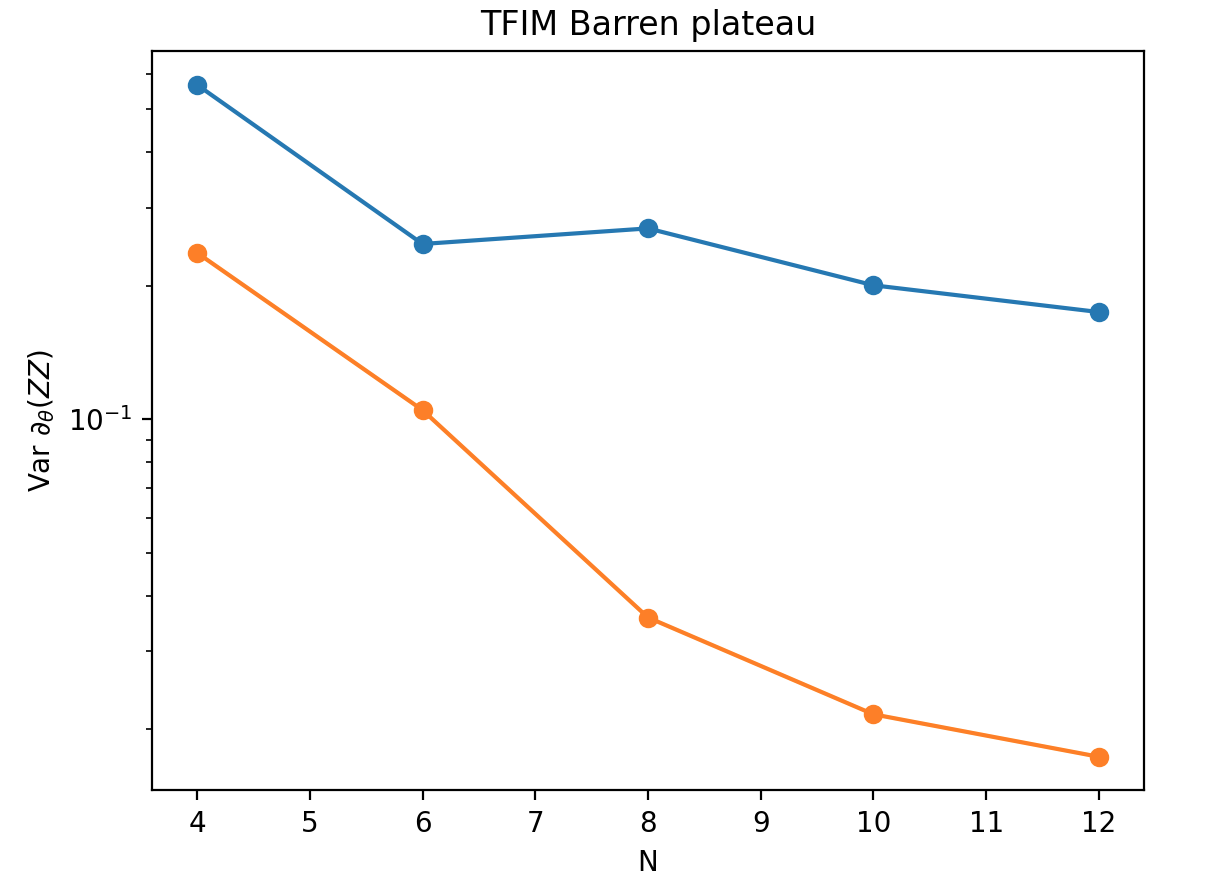

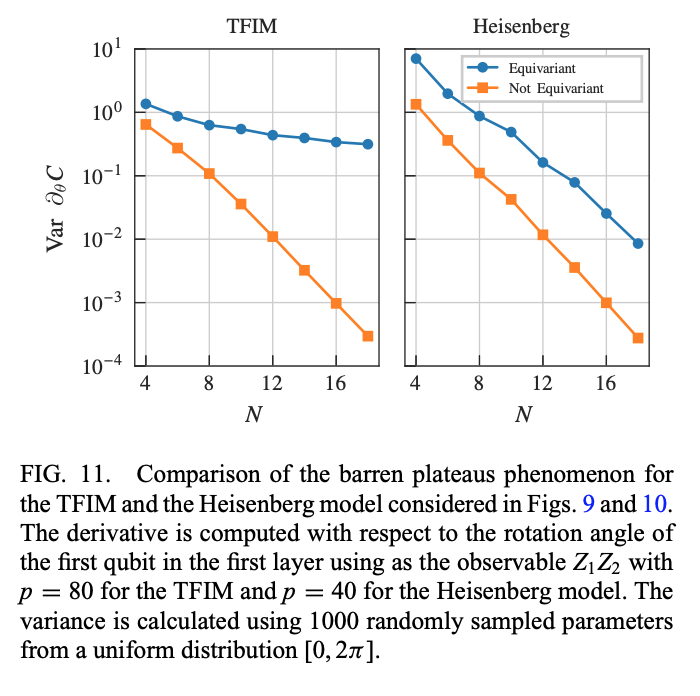

In [19]:
import re
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
Nlist = np.arange(4,19,2)

with open('barrenplateaus.res', 'r') as f:
    content = f.read()

    grads = re.sub(r"([^[])\s+([^]])", r"\1, \2", content)
    grads = np.array(literal_eval(grads))

    grad_inv = grads[0, :, :]
    grad_noinv = grads[1, :, :]

    #grads = re.sub(r"([^[])\s+()")

plt.plot(Nlist, np.var(grad_inv,axis=1), '-o', label='Equivariant')
plt.plot(Nlist, np.var(grad_noinv,axis=1), '-o',label='Not Equivariant')
plt.title('TFIM Barren plateau')
plt.ylabel(r'Var $\partial_\theta (ZZ)$')
plt.xlabel('N')
plt.yscale('log')

In [6]:
np.average(grad_noinv,axis=1)

array([-0.03574137, -0.05172662,  0.04380978, -0.0096972 , -0.00841086,
        0.01422011, -0.00672333,  0.00524259])

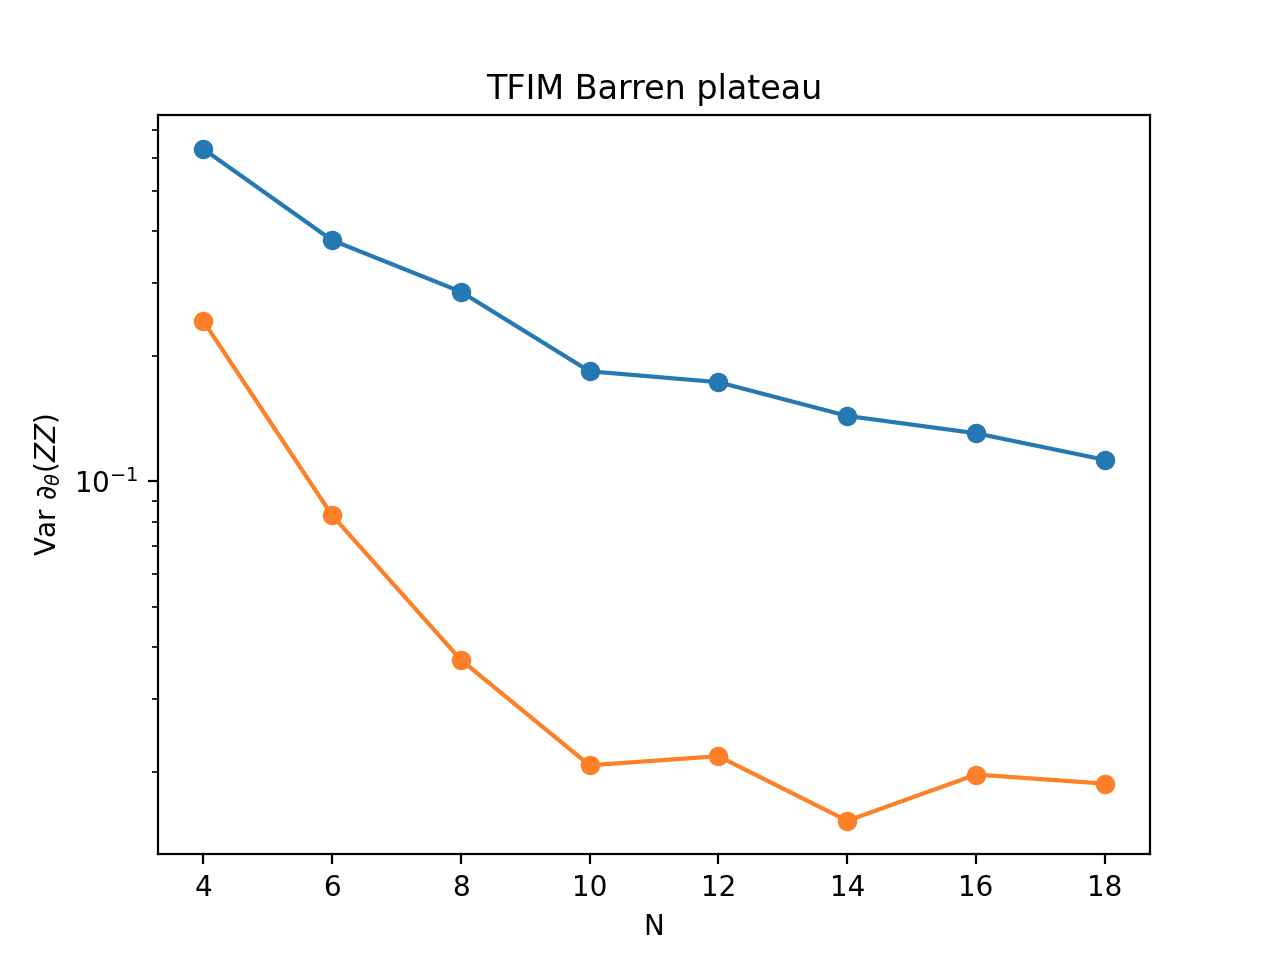

### Also translationally equivariant

In [38]:
#Now we implement things correctly...
#import sys
#sys.path.append('../modules/'
# Parmaterized Circuit: Invariant

qibo.gates.RZZ.generator_eigenvalue = lambda self: 0.5
def circ_inv(N, p):
    params = np.random.random((2*p,))*4*np.pi
    circuit_inv = Circuit(N)
    for q in range(N):
        circuit_inv.add(gates.H(q))  # WE START WITH |+> state
    for itp in range(p):
        for itzz in range(N):
            circuit_inv.add(gates.RZZ(itzz, (itzz+1)%N, params[2*itp]))
        for itx in range(N):
            circuit_inv.add(gates.RX(itx, params[2*itp + 1]))
    return circuit_inv, params

def circ_noinv(N, p):
    params2 = np.random.random((3*p,))*4*np.pi
    circuit_noinv = Circuit(N)
    for q in range(N):
        circuit_noinv.add(gates.H(q))
    for itp in range(p):
        for itzz in range(N):
            circuit_noinv.add(gates.RZZ(itzz, (itzz+1)%N, params2[3*itp]))
        for itx in range(N):
            circuit_noinv.add(gates.RX(itx, params2[3*itp + 1]))
        for ity in range(N):
            circuit_noinv.add(gates.RY(ity, params2[3*itp + 2]))
    return circuit_noinv, params2

def circs(N, p, g = 1, custom_operator=None):
    if custom_operator is None: 
        hamiltonian = hamiltonianTFI(N, g)
    else:
        hamiltonian = custom_operator
    
    circuit_inv, params = circ_inv(N,p)
    circuit_noinv, params2 = circ_noinv(N,p)

    def loss(params):
        circuit_inv.set_parameters(np.repeat(params,N))
        return hamiltonian.expectation(circuit_inv().state())

    def loss2(params):
        circuit_noinv.set_parameters(np.repeat(params,N))
        return hamiltonian.expectation(circuit_noinv().state())

    return circuit_inv, circuit_noinv, params, params2, loss, loss2


def circs_shots(N, p, g = 1, custom_operator=None, nshots=10000):
    if custom_operator is None: 
        hamiltonian = hamiltonianTFI(N, g)
    else:
        hamiltonian = custom_operator
    
    circuit_inv, params = circ_inv(N,p)
    circuit_noinv, params2 = circ_noinv(N,p)

    def loss(params):
        circuit_inv.set_parameters(np.repeat(params,N))
        return np.float64(hamiltonian.expectation_from_circuit(circuit_inv, nshots=nshots).real)

    def loss2(params):
        circuit_noinv.set_parameters(np.repeat(params,N))
        return np.float64(hamiltonian.expectation_from_circuit(circuit_noinv, nshots=nshots).real)

    return circuit_inv, circuit_noinv, params, params2, loss, loss2


In [27]:
## Testing that both circuits are the same but one is just noisy:
N = 6
p = 3; g = 1
circuit_inv, circuit_noinv, _, _, loss, loss2 = circs(N, p, g)
_, _, params, _, loss_shots, loss2_shots = circs_shots(N, p, g, nshots=10000)

print("State vector:    ", loss(params), "+/-",np.sqrt(2*N/10000))
print("Different shots: ", loss_shots(params),loss_shots(params),loss_shots(params))

f = [loss_shots(params) for _ in range(100)]
print("Manually computed variance:", np.sqrt(sum(l*l for l in f)/100 - (sum(l for l in f)/100)**2))

%timeit loss(params)
%timeit loss_shots(params)


State vector:     -1.014658200319146 +/- 0.034641016151377546
Different shots:  -0.9047999999999999 -0.9629999999999997 -1.009
Manually computed variance: 0.03461023548026447
5.56 ms ± 596 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
64.3 ms ± 9.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We observe here already a first 2*N factor, due to rerunning the circuit for each pauli term

In [30]:
# TO IMPLEMENT SHOT NOISE AND OTHER THINGS,
# DEFAULT OPTIMIZERS ARE NOT USEFUL, AS THEY CAN'T DEAL WITH NOISE:
# THEY USE FINITE DIFFERENCE METHODS TO COMPUTE GRADIENTS!!!!

# We need to define way to compute jacobian:
def circs_shots_jac(N, p, g = 1, custom_operator=None, nshots=4000):
    if custom_operator is None: 
        hamiltonian = hamiltonianTFI(N, g)
    else:
        hamiltonian = custom_operator
    circuit_inv, circuit_noinv, params, params2, loss, loss2 = circs_shots(N,p,g,custom_operator=custom_operator, nshots=nshots)
    gate_dependence_inv = {i: list(range(i*N, (i+1)*N)) for i in range(0,2*p)}
    gate_dependence_noinv = {i: list(range(i*N, (i+1)*N)) for i in range(0,3*p)}
    def jac_psr_inv(x, *args):
        circuit_inv.set_parameters(np.repeat(x,N))
        return np.array([parameter_shift(circuit_inv, hamiltonian, gate_dependence_inv[param], nshots=nshots, nruns=1) for param in range(len(params))])
    
    def jac_psr_noinv(x, *args):
        circuit_noinv.set_parameters(np.repeat(x,N))
        return np.array([parameter_shift(circuit_noinv, hamiltonian, gate_dependence_noinv[param], nshots=nshots, nruns=1) for param in range(len(params2))])

    return circuit_inv, circuit_noinv, params, params2, loss, loss2, jac_psr_inv, jac_psr_noinv

N = 6
gate_dependence_inv = {i: list(range(i*N, (i+1)*N)) for i in range(0,2*N,2)}

circuit_inv.set_parameters( circuit_inv.get_parameters())

_, _, params, _, loss, _, jac_psr, jac2 = circs_shots_jac(N, p, g)

for _ in range(10): print(jac_psr(params)[0])

for _ in range(10): print(loss(params))
 
#print(gate_dependence_inv)


SystemError: CPUDispatcher(<function apply_two_qubit_gate_kernel at 0x12ce220e0>) returned a result with an exception set

In [29]:
%timeit jac_psr(params)[0]

%timeit loss(params)

[Qibo 0.2.16|ERROR|2025-08-22 05:56:48]: Given list of parameters has length 24 while the circuit contains 48 parametrized gates.


ValueError: Given list of parameters has length 24 while the circuit contains 48 parametrized gates.

Performance: loss() is computing one circuit run, jac_psr() computes all gradients, which means finally 2 * (2 * N * p) runs of the circuit. This is indeed the ~ x92 factor observed

More efficient way is using smart grouping of terms that can be measured simultaously: example
https://qibo.science/qibochem/latest/tutorials/measurement.html


In [37]:
## Problem 4

# now we make a variational circuit

N = 5
p = 4
g = 1



hamiltonian = hamiltonianTFI(N, g)

ground_energy = hamiltonian.eigenvalues(1)[0]

print("Exact Ground State: ", ground_energy)



plist = np.array([2,4,6,8, 10])

Np = len(plist)
rep = 5

Elist_inv_shots = np.empty((Np, rep))
Nlist_inv_shots = np.empty((Np, rep))
Elist_noinv_shots = np.empty((Np, rep))
Nlist_noinv_shots = np.empty((Np, rep))


for itp in range(len(plist[:])):
    circuit_inv, circuit_noinv, params, params2, loss, loss2, jac1, jac2 = circs_shots_jac(N, plist[itp], nshots=4000)
    for itt in range(rep):
        print("P: ", itp, ",rep", itt)
        params = np.random.random((2*plist[itp],))*np.pi
        params2 = np.random.random((3*plist[itp],))*np.pi
        minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = 'parallel_L-BFGS-B', jac=jac1)
        Elist_inv_shots[itp,itt] = minE
        Nlist_inv_shots[itp,itt] = scipyRes.nit

        minE, minParams, scipyRes = qibo.optimizers.optimize(loss2, params2, method = 'parallel_L-BFGS-B', jac=jac2)
        Elist_noinv_shots[itp,itt] = minE
        Nlist_noinv_shots[itp,itt] = scipyRes.nit

#minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")
        
print(Elist_inv_shots)
print()
print(Nlist_inv_shots)
print()
print(Elist_noinv_shots)
print()
print(Nlist_noinv_shots)


[Qibo 0.2.16|WARNING|2025-08-22 06:39:20]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Exact Ground State:  -6.472135954999578
P:  0 ,rep 0


TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [85]:
scipyRes

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -6.1834999999999996
        x: [ 8.934e-01  2.321e+00  2.885e+00  2.086e+00  4.417e-02
             2.287e+00  2.074e+00  2.521e+00  1.130e+00  2.165e+00
             1.078e+00  1.717e+00]
      nit: 10
      jac: [ 9.027e-01  5.738e-01  2.450e-02  8.957e-01 -1.465e-01
            -1.212e+00  7.560e-01 -9.862e-01  8.400e-02  1.888e-01
            -2.975e-01 -2.970e-01]
 hess_inv: [[ 2.957e-01 -1.431e-01 ...  2.477e-01  1.824e-02]
            [-1.431e-01  8.113e-01 ... -2.718e-01 -5.421e-02]
            ...
            [ 2.477e-01 -2.718e-01 ...  9.942e-01 -8.133e-02]
            [ 1.824e-02 -5.421e-02 ... -8.133e-02  3.730e-01]]
     nfev: 35
     njev: 28

In [71]:
fig, axs = plt.subplots(2,1, sharex=True)
plt.xlabel('N')

gse = -6.472135954999578

print(len(plist))

print(len(Elist_inv))

axs[0].set_title('Convergence Comparison (L-BFGS) with 10 qubits')
axs[0].errorbar(plist, np.average(Elist_inv-gse, axis=1), fmt='-o', yerr=np.sqrt(np.var(Elist_inv-gse, axis=1)), label='Equivariant')
axs[0].errorbar(plist, np.average(Elist_noinv-gse, axis=1), fmt='-s', yerr=np.sqrt(np.var(Elist_noinv-gse, axis=1)), label='Non Equivariant')
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].legend(loc='upper right')

axs[1].errorbar(plist, np.average(Nlist_inv, axis=1), fmt='-o', yerr=np.sqrt(np.var(Nlist_inv, axis=1)), label='Equivariant')
axs[1].errorbar(plist, np.average(Nlist_noinv, axis=1), fmt='-s', yerr=np.sqrt(np.var(Nlist_noinv, axis=1)), label='Non Equivariant')
axs[1].set_ylabel('Iterations')

6
6


/Users/JFAMcBookPro/opt/anaconda3/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Text(0, 0.5, 'Iterations')

no shot noise 6 qubits
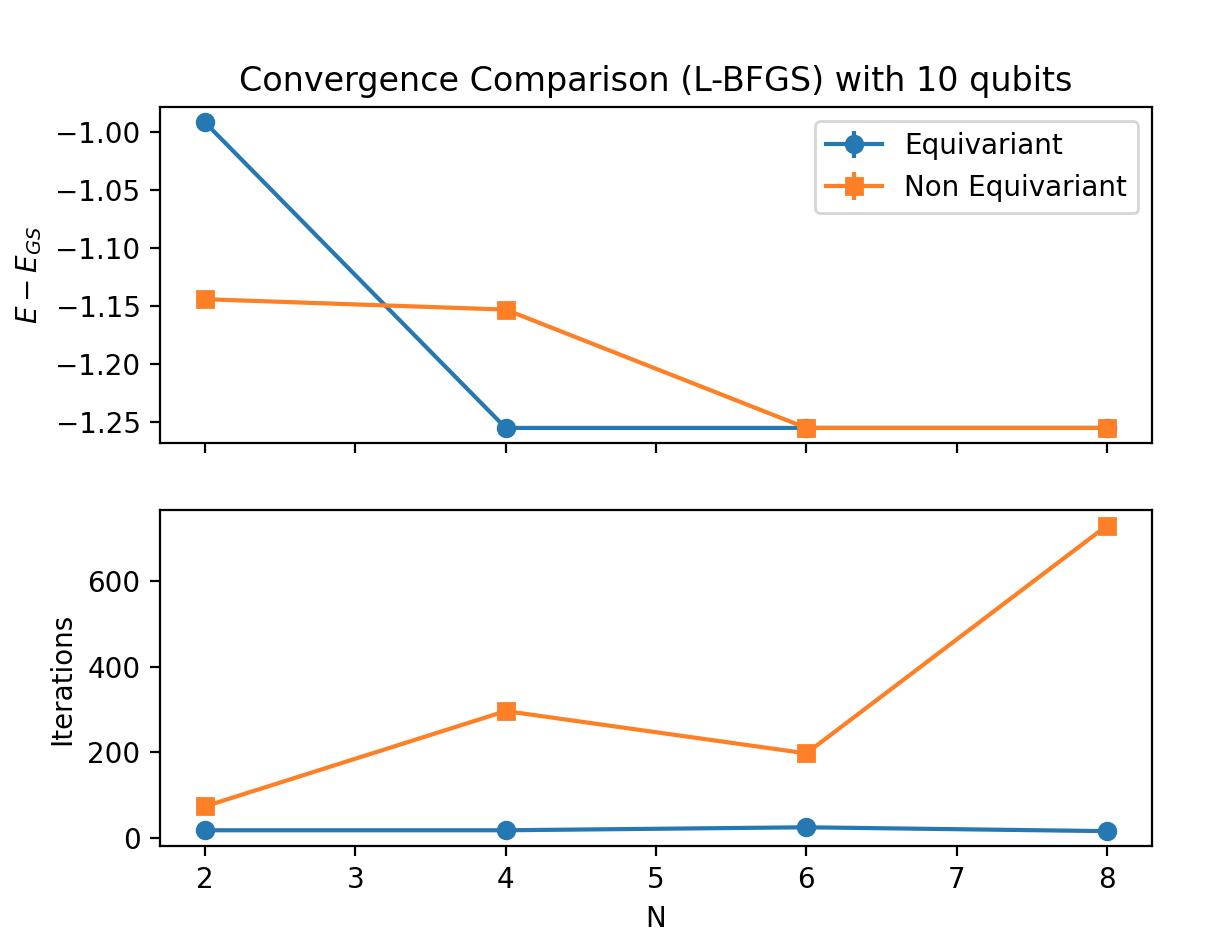

yes shot noise (1 ??? bad)

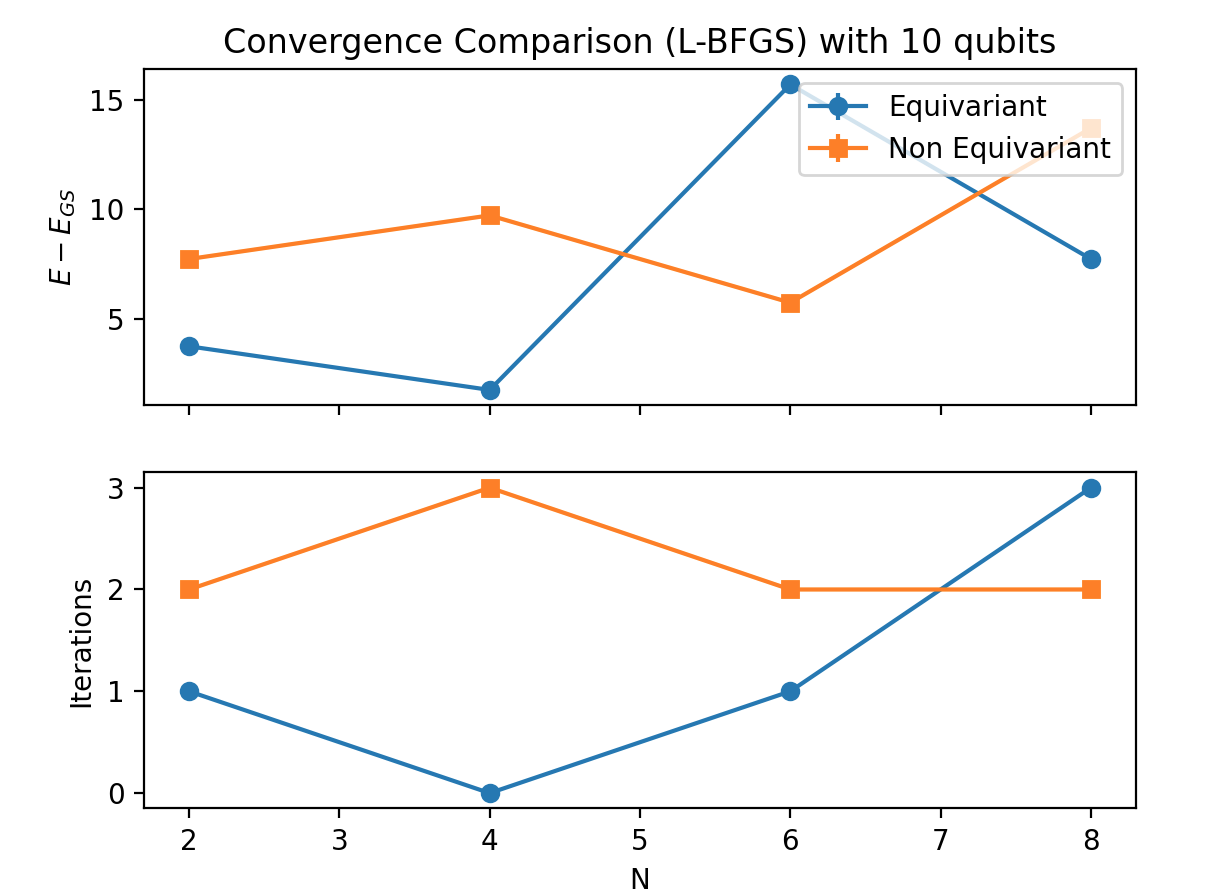


In [205]:
## Problem 4

# now we make a variational circuit

N = 6
p = 4
g = 1



hamiltonian = Hamiltonian(N, g)

ground_energy = hamiltonian.eigenvalues(1)[0]

print("Exact Ground State: ", ground_energy)



plist = np.array([2,4,6,8])

Np = len(plist)
rep = 1

Elist_inv = np.empty((Np, rep))
Nlist_inv = np.empty((Np, rep))
Elist_noinv = np.empty((Np, rep))
Nlist_noinv = np.empty((Np, rep))


for itp in range(len(plist[:])):
    circuit_inv, circuit_noinv, params, params2, loss, loss2 = circs(N, plist[itp])
    for itt in range(rep):
        print("P: ", itp, ",rep", itt)
        params = np.random.random((2*plist[itp],))*np.pi
        params2 = np.random.random((3*plist[itp],))*np.pi
        minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = 'parallel_L-BFGS-B')
        Elist_inv[itp,itt] = minE
        Nlist_inv[itp,itt] = scipyRes.nit

        minE, minParams, scipyRes = qibo.optimizers.optimize(loss2, params2, method = 'parallel_L-BFGS-B')
        Elist_noinv[itp,itt] = minE
        Nlist_noinv[itp,itt] = scipyRes.nit

#minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")
        
print(Elist_inv)
print()
print(Nlist_inv)
print()
print(Elist_noinv)
print()
print(Nlist_noinv)


[Qibo 0.2.16|WARNING|2025-05-06 18:00:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Exact Ground State:  -7.72740661031255
P:  0 ,rep 0
P:  1 ,rep 0
P:  2 ,rep 0
P:  3 ,rep 0
[[-7.46410161]
 [-7.72740661]
 [-7.72740661]
 [-7.7274066 ]]

[[17.]
 [17.]
 [24.]
 [15.]]

[[-7.61646139]
 [-7.62540912]
 [-7.72740604]
 [-7.72740497]]

[[ 73.]
 [296.]
 [197.]
 [730.]]


In [15]:
import json
import numpy as np
import matplotlib.pyplot as plt

Njobs = 4
jobrange = range(Njobs)

plist = np.array([2,4,6,8,10,12])

Np = len(plist)
rep = 5

Elist_inv_tot = np.empty((Np, rep*Njobs))
Nlist_inv_tot = np.empty((Np, rep*Njobs))
Elist_noinv_tot = np.empty((Np, rep*Njobs))
Nlist_noinv_tot = np.empty((Np, rep*Njobs))


for job in jobrange:
    """Elist_inv = np.empty((Np, rep))
    Nlist_inv = np.empty((Np, rep))
    Elist_noinv = np.empty((Np, rep))
    Nlist_noinv = np.empty((Np, rep))"""
    with open(f'tfi{job}.json', 'r') as f:
        storedlists = json.load(f)

    Elist_inv = np.array(storedlists["Elist_inv"])
    Nlist_inv = np.array(storedlists["Nlist_inv"])
    Elist_noinv = np.array(storedlists["Elist_noinv"])
    Nlist_noinv = np.array(storedlists["Nlist_noinv"])

    Elist_inv_tot[:, rep*job:rep*(job+1)] = Elist_inv
    Nlist_inv_tot[:, rep*job:rep*(job+1)] = Nlist_inv
    Elist_noinv_tot[:, rep*job:rep*(job+1)] = Elist_noinv
    Nlist_noinv_tot[:, rep*job:rep*(job+1)] = Nlist_noinv

gse = -12.784906442999327

e1list = Elist_inv_tot
n1list = Nlist_inv_tot
e2list = Elist_noinv_tot
n2list = Nlist_noinv_tot


fig, axs = plt.subplots(2,1, sharex=True)
plt.xlabel('L')

"""axs[0].set_title('Convergence Comparison (L-BFGS) with 10 qubits')
for reps in range(e1list.shape[1]):
    axs[0].plot(plist, e1list[:,reps]-gse, '-o', c='orange', label='Equivariant')
    axs[0].plot(plist, e2list[:,reps]-gse, '--s', c='blue',  label='Non Equivariant')
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].legend(loc='upper right')

axs[1].errorbar(plist, np.average(n1list, axis=1), fmt='-o', yerr=np.sqrt(np.var(n1list, axis=1)))#, label='Equivariant')
axs[1].errorbar(plist, np.average(n2list, axis=1), fmt='-s', yerr=np.sqrt(np.var(n2list, axis=1)))#, label='Non Equivariant')
axs[1].set_ylabel('Iterations')"""


#Classic
axs[0].set_title('Convergence Comparison (L-BFGS) with 10 qubits')
axs[0].errorbar(plist, np.average(e1list-gse, axis=1), fmt='-o', yerr=np.sqrt(np.var(e1list-gse, axis=1)), label='Equivariant')
axs[0].errorbar(plist, np.average(e2list-gse, axis=1), fmt='-s', yerr=np.sqrt(np.var(e2list-gse, axis=1)), label='Non Equivariant')
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].legend(loc='upper right')

axs[1].errorbar(plist, np.average(n1list, axis=1), fmt='-o', yerr=np.sqrt(np.var(n1list, axis=1)), label='Equivariant')
axs[1].errorbar(plist, np.average(n2list, axis=1), fmt='-s', yerr=np.sqrt(np.var(n2list, axis=1)), label='Non Equivariant')
axs[1].set_ylabel('Iterations')

Text(0, 0.5, 'Iterations')

In [53]:
plt.show()

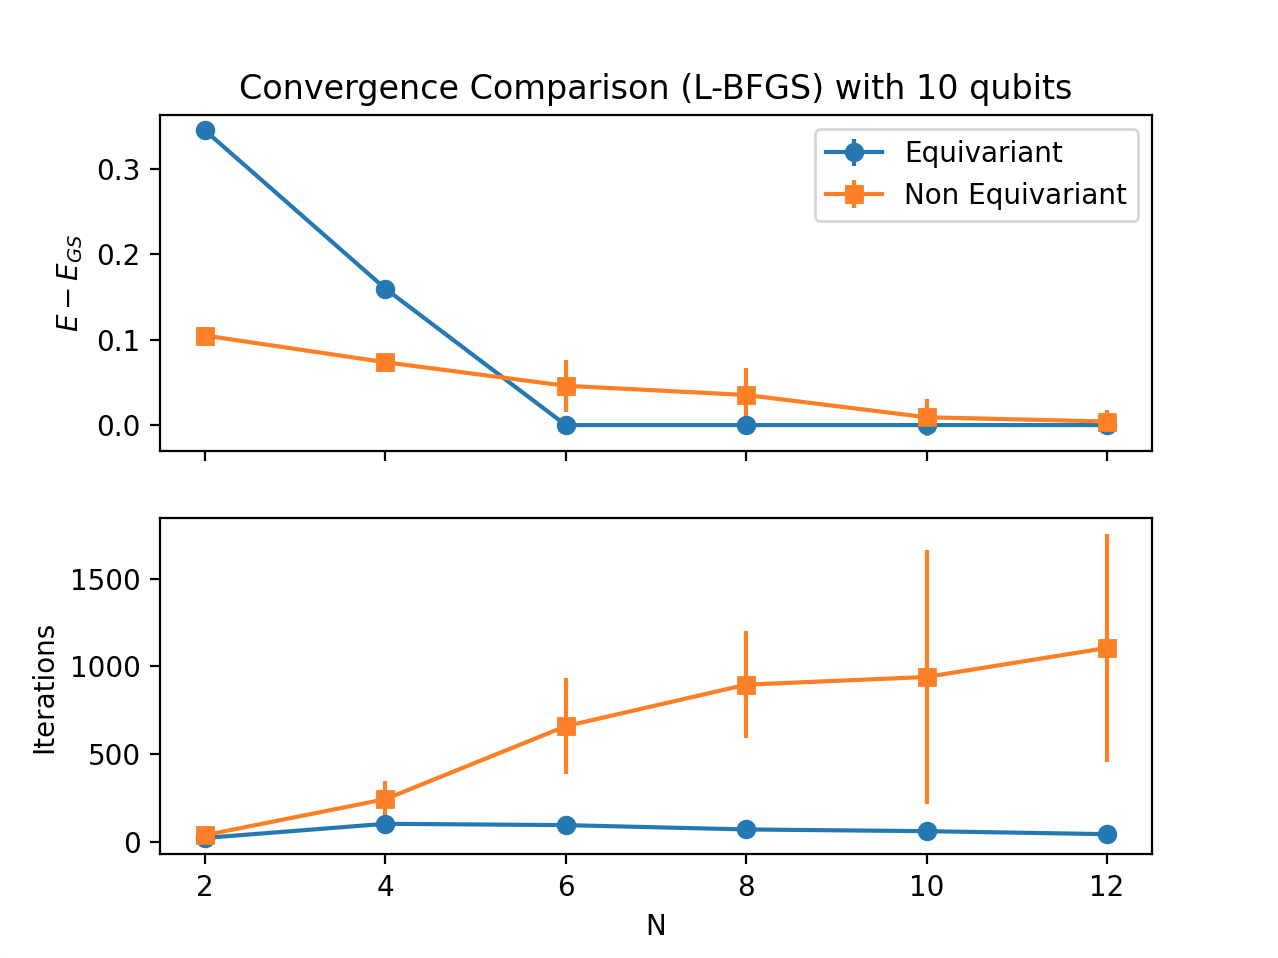

Finally

And now finally again we compute the barren plateaus phenomena but with the correct circuits

In [76]:
qibo.set_backend("qibojit")

g = 1

rep = 10
p = 80

Nlist = range(4,9,2)
nN = len(Nlist)

grad_inv = np.empty((nN, rep))
grad_noinv = np.empty((nN, rep))

custzz = qibo.hamiltonians.SymbolicHamiltonian(Z(0)*Z(1))

for itn, N in enumerate(Nlist):
    print(N)
    hamiltonian = Hamiltonian(N, g)

    circuit_inv, circuit_noinv, params, params2, loss, loss2 = circs(N, p, custom_operator = custzz)
    for itt in range(rep):
        
        params = np.random.random((2*p,))*np.pi*4
        params2 = np.random.random((3*p,))*np.pi*4
        circuit_inv.set_parameters(np.repeat(params,N))
        circuit_noinv.set_parameters(np.repeat(params2,N))
        grad_inv[itn,itt] = parameter_shift(circuit_inv, hamiltonian, 0)
        grad_noinv[itn,itt] = parameter_shift(circuit_noinv, hamiltonian, 0)

#minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")


[Qibo 0.2.16|INFO|2025-04-25 05:12:42]: Using qibojit (numba) backend on /CPU:0


4
6
8


In [47]:
#### IN THIS CODE WE STUDY THE BARREN PLATEAUS PHENOMENON FOR AN EQUIVARIANT EIGENSOLVER
#### REPLICATING THE PAPER - EXPLOTIING EQUIVARIATN CIRCUITS 
from qibo.derivative import parameter_shift
import sys
import json

#FILENUMBER = sys.argv[1]
rep = 400; p = 80
Nlist = range(4,17,2)
nN = len(Nlist)

qibo.set_backend("qibojit")

g = 1

grad_inv = np.empty((nN, rep))
grad_noinv = np.empty((nN, rep))

custzz = qibo.hamiltonians.SymbolicHamiltonian(Z(0)*Z(1))

for itn, N in enumerate(Nlist):
    print(N)
    p = N
    hamiltonian = hamiltonianTFI(N, g)

    circuit_inv, circuit_noinv, params, params2, loss, loss2 = circs(N, p, custom_operator = custzz)
    for itt in range(rep):
        
        params = np.random.random((2*p,))*np.pi*4
        params2 = np.random.random((3*p,))*np.pi*4
        circuit_inv.set_parameters(np.repeat(params,N))
        circuit_noinv.set_parameters(np.repeat(params2,N))
        grad_inv[itn,itt] = parameter_shift(circuit_inv, hamiltonian, 0)
        grad_noinv[itn,itt] = parameter_shift(circuit_noinv, hamiltonian, 0)

print(grad_inv, grad_noinv)

[Qibo 0.2.16|INFO|2025-08-20 16:59:10]: Using qibojit (numba) backend on /CPU:0


4
6
8
10
12
14
16
[[ 0.26526735  0.44796804  1.39525101 ...  0.46150847  0.81016724
  -0.97181432]
 [-0.75957358 -0.72614386 -0.18851619 ...  0.84394524  0.16274178
  -0.81136627]
 [ 0.27663245  0.85363614 -0.27935472 ...  0.49770809 -0.0858272
   0.43895621]
 ...
 [ 0.13430798  0.59991356  0.17182819 ...  0.67843828  0.52751091
   0.96449694]
 [-0.72440212 -0.5612276   0.31270492 ...  0.08781961  0.33059327
   0.73142151]
 [-0.55216959  0.80879432  0.92056806 ...  0.02963744  0.079902
   0.00860545]] [[ 0.65616501  0.15185215  0.08896189 ...  0.60418336 -0.29602184
  -0.9213482 ]
 [-0.69388924 -0.60459255 -0.72301885 ...  0.57626651  0.03931901
   0.4011677 ]
 [-0.17897582 -0.12217942  0.3182323  ... -0.08802059  0.19136908
   0.02441334]
 ...
 [-0.20499329 -0.41319723 -0.26461703 ... -0.19907637 -0.08282554
  -0.20116215]
 [-0.06731765 -0.06149429 -0.44178795 ...  0.04826735  0.01403565
  -0.10358036]
 [ 0.08102977 -0.22860723  0.39793887 ... -0.05964329  0.13745026
  -0.02207474]]


In [78]:
import re
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
"""Nlist = np.arange(4,19,2)

grad_inv = np.empty((len(Nlist), 100))
grad_noinv = np.empty((len(Nlist), 100))

with open('barrenplateaus_good.res', 'r') as f:
    content = f.read()

    grads = re.sub(r"([^[])\s+([^]])", r"\1, \2", content)
    grads = np.array(literal_eval(grads))

    #grad_inv = grads[0::2, :, :].reshape((len(Nlist), 10*10))
    #grad_noinv = grads[1::2, :, :].reshape((len(Nlist), 10*10))

    #grads = re.sub(r"([^[])\s+()")

for copy in range(10):
    grad_inv[:, 10*copy:10*(copy+1)] = grads[2*copy, :, :]
    grad_noinv[:, 10*copy:10*(copy+1)] = grads[2*copy+1, :, :]"""

plt.plot(Nlist, np.var(grad_inv,axis=1), '-o', label='Equivariant')
plt.plot(Nlist, np.var(grad_noinv,axis=1), '-o',label='Not Equivariant')
plt.legend()
plt.title('TFIM Barren plateau')
plt.ylabel(r'Var $\partial_\theta (ZZ)$')
plt.xlabel('N')
plt.yscale('log')

NameError: name 'Nlist' is not defined

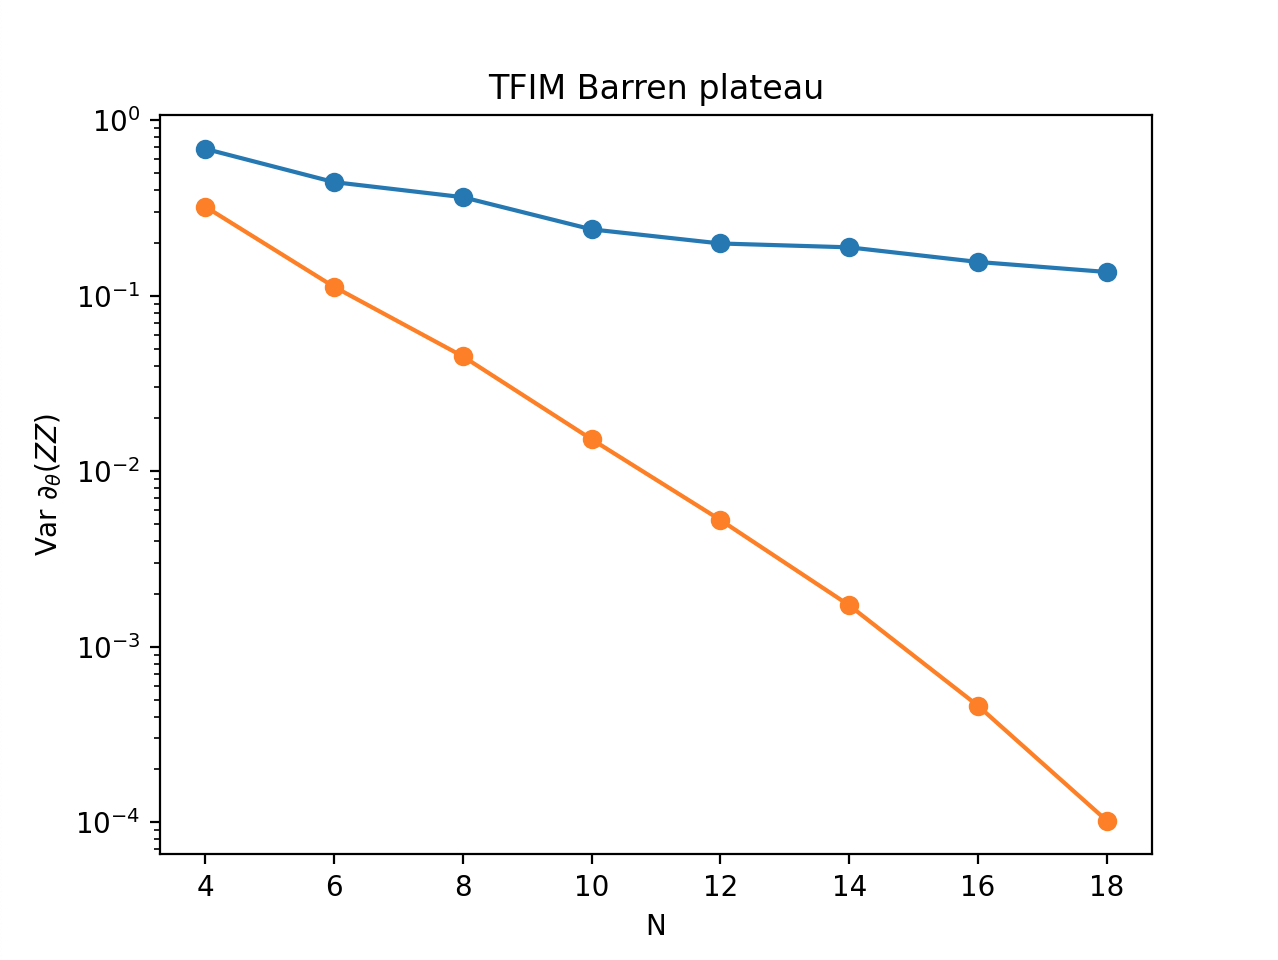

Is this valid? The problem to be seen with this is that we are judging the barren plateaus phenomena but we are measuring the gradient with respect to a single qubit parameter. The parameter itself varies all qubits the same due to translational symmetry being considered.

Therefore, the negligence of this means this analysis may not be as useful as it seems. With our training, our impediment or enabler to training would be the gradients of our parameter, which depend on its actuation on all qubits. The gradients plotted here are not those of our parameter!

In [17]:
grads[::2,:,:].reshape((len(Nlist), 100))

array([[-1.75038666e+00,  7.66336830e-01, -1.47845600e-02,
         8.58889910e-01, -2.71318540e-01,  3.89738380e-01,
        -9.77891080e-01,  1.46874537e+00,  1.40896110e-01,
        -9.63919890e-01,  1.04045968e+00, -1.27268827e+00,
         1.31892390e-01, -6.66592660e-01, -1.90933000e-01,
        -7.66466400e-02,  8.49266860e-01, -8.65876270e-01,
        -1.19756851e+00,  3.78061810e-01, -7.10489820e-01,
         2.93342230e-01,  7.63973410e-01, -4.14633120e-01,
         9.38545120e-01, -5.59279800e-01,  7.19813740e-01,
         5.78954950e-01, -6.45073420e-01,  1.39167899e+00,
         6.83523670e-01,  3.51385310e-01,  1.81155150e-01,
        -4.45783000e-03,  7.44800400e-02, -6.08492620e-01,
         6.16278570e-01,  6.15498090e-01,  2.20219080e-01,
        -2.90472420e-01, -4.82079740e-01, -1.41231440e-01,
        -4.89862770e-01,  6.44967050e-01, -5.70781870e-01,
        -5.58917730e-01,  9.38674190e-01,  4.36026690e-01,
        -5.28470890e-01, -3.84437820e-01,  4.14563870e-0

In [8]:
mm = np.array([[[0., 0.], [0., 0.]],
               [[1., 1.], [1., 1.]],
               [[2., 2.], [2., 3.]],])

mm.reshape((3,4))

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [2., 2., 2., 3.]])

### Noisy models

For these models to be useful they need to be implementable, and we had been ignoring until now the implications of such a thing.

In a real quantum computer we won't have access to exact state vectors nor expectation values, all we will have are samples. This shot noise will be there even in ideal circumstances. 
On the other hand, there is also non-ideal noise, due to decoherence, imperfect gates, etc.

Now there is a tradeoff to consider, we can either work with density matrices, but this effectively "doubles" the number of qubits in terms of computation cost. The other option offered by qibo is to not work in the density matrix formalism and apply errors randomly. The problem of this latter one is then that for each nshot, the circuit needs to be rerun as the errors during execution are random, and it's a bit less expressive.


We can consider cases:

What if the noise respects the symmetries? 


What if it doesn't?

In [76]:
## With noise, some optimizers don't behave as well. For instance BFGS

# We tried implementing a noise resiliant alternative but it does not seem to work too well, because it stops convergence up to random error
# But we know we can keep running Gradient Descent, and stochastically it will converge


# We implement here a simple gradient descent, with a simple learning rate hyperparameter
def optimizer_gds(parameters, loss, gradient, Nepochs=250, lr=1e-2, epochs_print = 50, hyper={}, return_gradients=False):
    loss_list = np.empty((Nepochs,))
    if return_gradients: grad_list = np.empty((Nepochs,))
    for epoch in range(Nepochs):
        grad_val = gradient(parameters)
        parameters = parameters - lr * grad_val
        
        loss_val = loss(parameters)
        if epoch % epochs_print == 0 or epoch == Nepochs - 1:
            print(f"Epoch {epoch}, Loss: {loss_val}")

        loss_list[epoch] = loss_val
        if return_gradients: grad_list[epoch] = grad_val
    
    if return_gradients: return parameters, loss_list, grad_list
    return parameters, loss_list

#### Shot Noise

First we implement only shot noise

In [77]:
N = 5
nshots = None
Nepochs = 20
p = 2

circuit_inv, circuit_noinv, params, params2, loss, loss2, jac1, jac2 = circs_shots_jac(N, p, nshots=nshots)

_, loss_list = optimizer_gds(params, loss, jac1, Nepochs = Nepochs, epochs_print=Nepochs/10)

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [90]:
epoch_range = np.arange(Nepochs)
error = np.sqrt(2*N/nshots)
plt.plot(epoch_range, loss_list)
plt.fill_between(epoch_range, loss_list+error, loss_list-error, alpha=0.1)
plt.plot([0,Nepochs-1],[min(loss_list)]*2, '--')
plt.plot([0,Nepochs-1],[-12.784906442999327]*2, '-.')


Convergence of N=10, p=4. lr=0.01
Nshots=4000
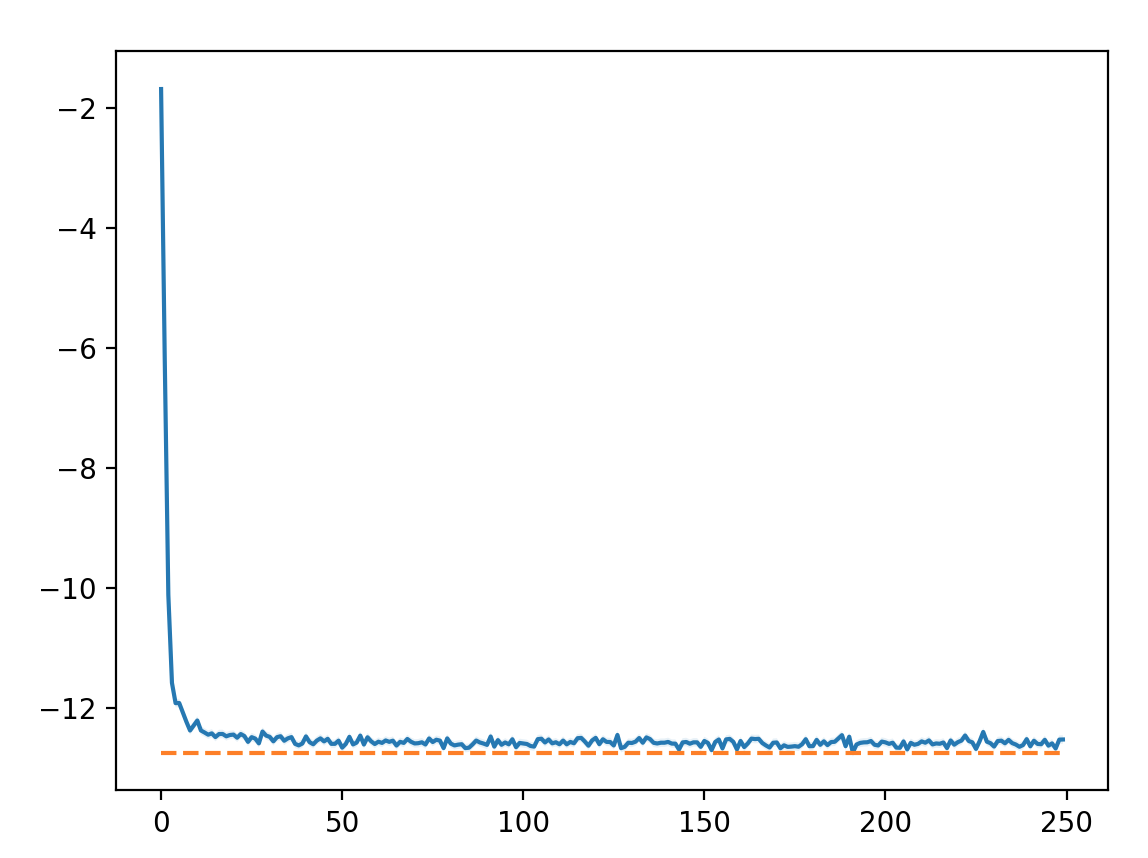

lr=0.004 Nshots=4000
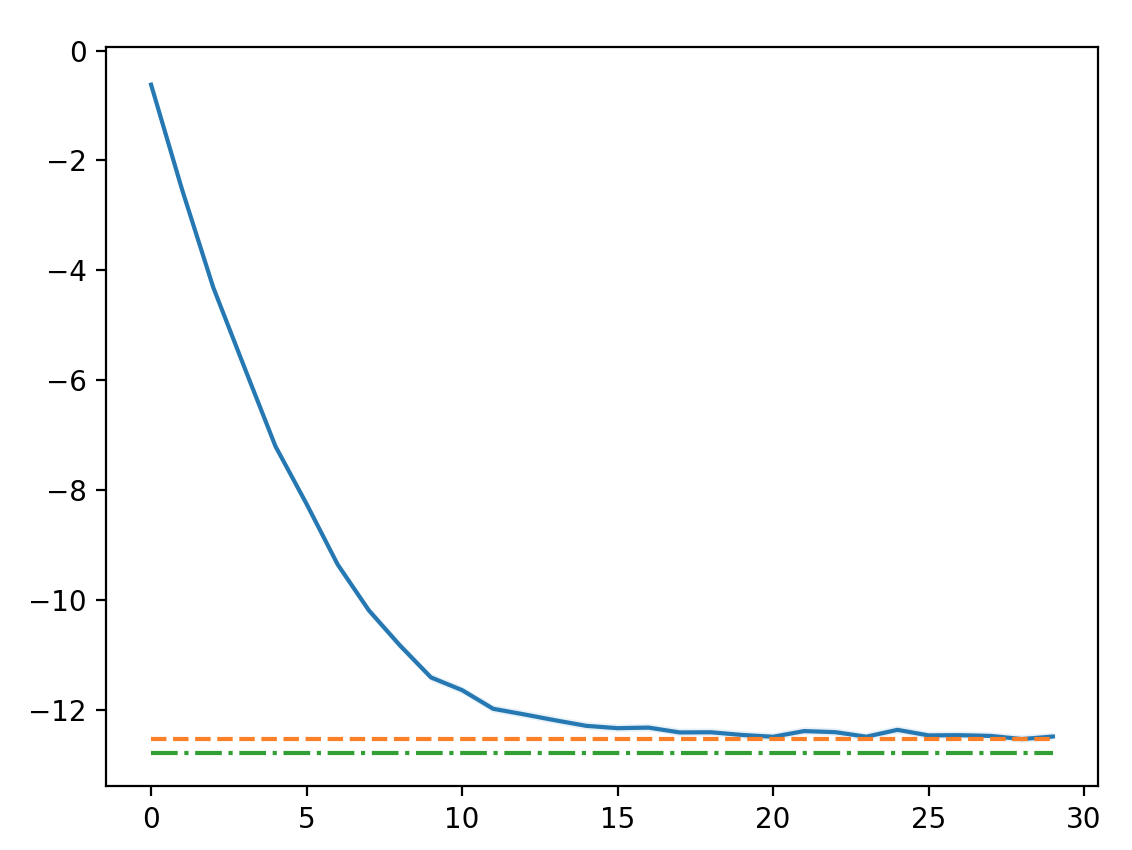

Nshots = 400
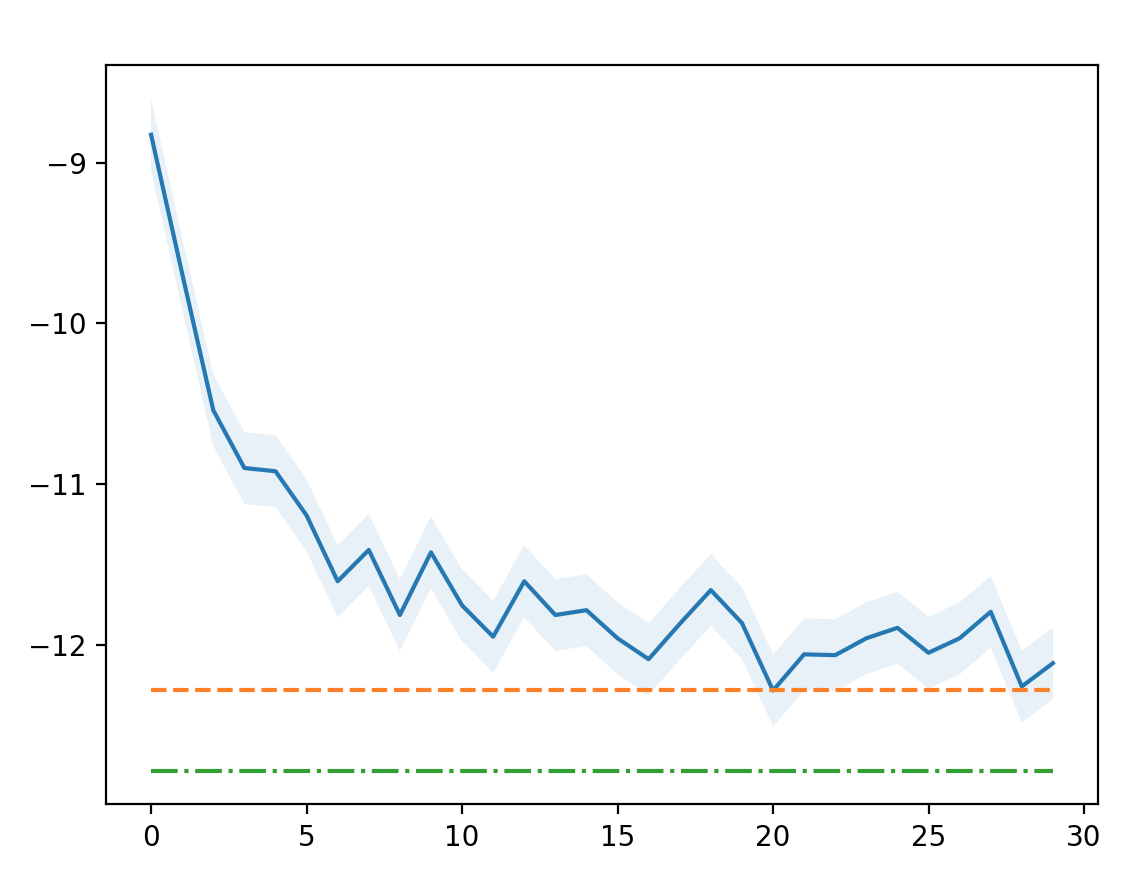

In [87]:
N = 10
nshots = 40000
Nepochs = 30
p = 4
lr = 0.4e-2

circuit_inv, circuit_noinv, params, params2, loss, loss2, jac1, jac2 = circs_shots_jac(N, p, nshots=nshots)

_, loss_list = optimizer_gds(params, loss, jac1, Nepochs = Nepochs, epochs_print=Nepochs/5, lr=lr)

Epoch 0, Loss: -0.6521
Epoch 6, Loss: -8.95735
Epoch 12, Loss: -11.63125
Epoch 18, Loss: -12.1231
Epoch 24, Loss: -12.2343
Epoch 29, Loss: -12.308950000000001


In [10]:
def circs(N, p, g = 1, custom_operator=None, nshots=1000):
    if custom_operator is None: 
        hamiltonian = hamiltonianTFI(N, g)
    else:
        hamiltonian = custom_operator
    
    circuit_inv, params = circ_inv(N,p)
    circuit_noinv, params2 = circ_noinv(N,p)

    def loss(params):
        circuit_inv.set_parameters(np.repeat(params,N))
        return np.float64(hamiltonian.expectation_from_circuit(circuit_inv, nshots=nshots).real)

    def loss2(params):
        circuit_noinv.set_parameters(np.repeat(params,N))
        return np.float64(hamiltonian.expectation_from_circuit(circuit_noinv, nshots=nshots).real)

    return circuit_inv, circuit_noinv, params, params2, loss, loss2

In [52]:
import json

Njobs = 5
jobrange = range(Njobs)

plist = np.array([2,4,6,8,10,12])

Np = len(plist)
rep = 4

Elist_inv_tot = np.empty((Np, rep*Njobs))
Nlist_inv_tot = np.empty((Np, rep*Njobs))
Elist_noinv_tot = np.empty((Np, rep*Njobs))
Nlist_noinv_tot = np.empty((Np, rep*Njobs))


for job in jobrange:
    """Elist_inv = np.empty((Np, rep))
    Nlist_inv = np.empty((Np, rep))
    Elist_noinv = np.empty((Np, rep))
    Nlist_noinv = np.empty((Np, rep))"""
    with open(f'./data/tfishotn10_{job}.json', 'r') as f:
        storedlists = json.load(f)

    Elist_inv = np.array(storedlists["Elist_inv"])
    Nlist_inv = np.array(storedlists["Nlist_inv"])
    Elist_noinv = np.array(storedlists["Elist_noinv"])
    Nlist_noinv = np.array(storedlists["Nlist_noinv"])

    Elist_inv_tot[:, rep*job:rep*(job+1)] = Elist_inv
    Nlist_inv_tot[:, rep*job:rep*(job+1)] = Nlist_inv
    Elist_noinv_tot[:, rep*job:rep*(job+1)] = Elist_noinv
    Nlist_noinv_tot[:, rep*job:rep*(job+1)] = Nlist_noinv

gse = -12.784906442999327

e1list = Elist_inv_tot
n1list = Nlist_inv_tot
e2list = Elist_noinv_tot
n2list = Nlist_noinv_tot


fig, axs = plt.subplots(2,1, sharex=True)
plt.xlabel('L')

axs[0].set_title('Convergence Comparison (L-BFGS) with 10 qubits (and shot noise)')
axs[0].errorbar(plist, np.average(e1list-gse, axis=1), fmt='-o', yerr=np.sqrt(np.var(e1list-gse, axis=1)), label='Equivariant')
axs[0].errorbar(plist, np.average(e2list-gse, axis=1), fmt='-s', yerr=np.sqrt(np.var(e2list-gse, axis=1)), label='Non Equivariant')
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].legend(loc='upper right')

axs[1].errorbar(plist, np.average(n1list, axis=1), fmt='-o', yerr=np.sqrt(np.var(n1list, axis=1)), label='Equivariant')
axs[1].errorbar(plist, np.average(n2list, axis=1), fmt='-s', yerr=np.sqrt(np.var(n2list, axis=1)), label='Non Equivariant')
axs[1].set_ylabel('Iterations')

Text(0, 0.5, 'Iterations')

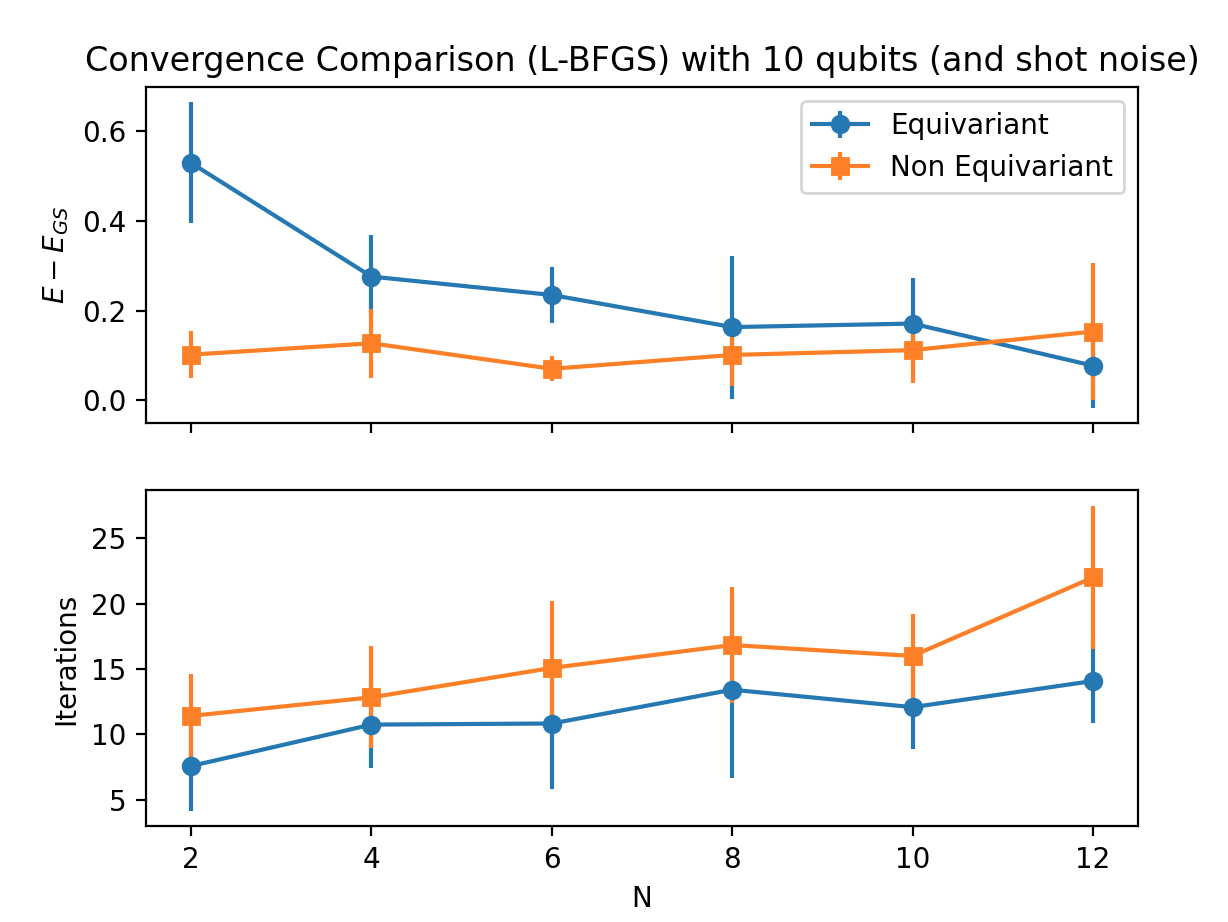

In [14]:
import json

Njobs = 2
N = 6
jobrange = range(Njobs)

plist = np.array([2,4,6,8,10])

Np = len(plist)
rep = 4

Elist_inv_tot = np.empty((Np, rep*Njobs))
Nlist_inv_tot = np.empty((Np, rep*Njobs))
Elist_noinv_tot = np.empty((Np, rep*Njobs))
Nlist_noinv_tot = np.empty((Np, rep*Njobs))


for job in jobrange:
    """Elist_inv = np.empty((Np, rep))
    Nlist_inv = np.empty((Np, rep))
    Elist_noinv = np.empty((Np, rep))
    Nlist_noinv = np.empty((Np, rep))"""
    with open(f'./data/tfishotn{N}_{job}.json', 'r') as f:
        storedlists = json.load(f)

    Elist_inv = np.array(storedlists["Elist_inv"])
    Nlist_inv = np.array(storedlists["Nlist_inv"])
    Elist_noinv = np.array(storedlists["Elist_noinv"])
    Nlist_noinv = np.array(storedlists["Nlist_noinv"])

    Elist_inv_tot[:, rep*job:rep*(job+1)] = Elist_inv
    Nlist_inv_tot[:, rep*job:rep*(job+1)] = Nlist_inv
    Elist_noinv_tot[:, rep*job:rep*(job+1)] = Elist_noinv
    Nlist_noinv_tot[:, rep*job:rep*(job+1)] = Nlist_noinv

gse = -7.72740661031255

e1list = Elist_inv_tot
n1list = Nlist_inv_tot
e2list = Elist_noinv_tot
n2list = Nlist_noinv_tot


fig, axs = plt.subplots(2,1, sharex=True)
plt.xlabel('N')

axs[0].set_title(f'Convergence Comparison (L-BFGS) with {N} qubits (and shot noise)')
axs[0].errorbar(plist, np.average(e1list-gse, axis=1), fmt='-o', yerr=np.sqrt(np.var(e1list-gse, axis=1)), label='Equivariant')
axs[0].errorbar(plist, np.average(e2list-gse, axis=1), fmt='-s', yerr=np.sqrt(np.var(e2list-gse, axis=1)), label='Non Equivariant')
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].legend(loc='upper right')

axs[1].errorbar(plist, np.average(n1list, axis=1), fmt='-o', yerr=np.sqrt(np.var(n1list, axis=1)), label='Equivariant')
axs[1].errorbar(plist, np.average(n2list, axis=1), fmt='-s', yerr=np.sqrt(np.var(n2list, axis=1)), label='Non Equivariant')
axs[1].set_ylabel('Iterations')

Text(0, 0.5, 'Iterations')

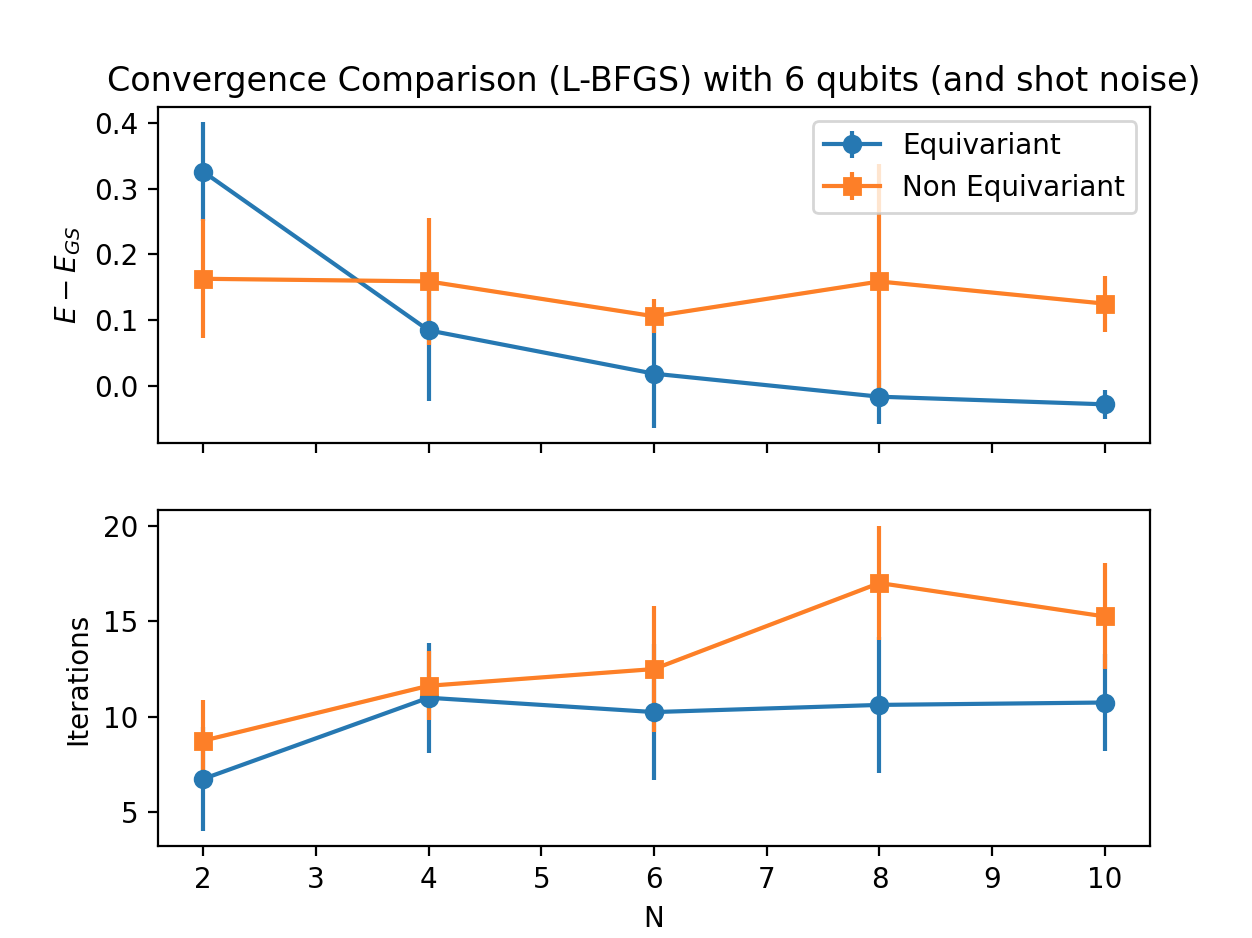

In [52]:
# We can use qibo : circuit.with_pauli_noise(noise_map)

N = 5

epsilon = 1e-2

noise_map = {i: list(zip(["X", "Z"], [epsilon, epsilon])) for i in range(N)}

circ_inv(N, 3)[0].with_pauli_noise(noise_map).draw()


0:     ─H─PN─RZZ─PN──────────────────────RZZ─PN─RX─PN─RZZ─PN───────────────── ...
1:     ─H─PN─RZZ─PN─RZZ─PN───────────────|───RX─PN────RZZ─PN─RZZ─PN────────── ...
2:     ─H─PN────────RZZ─PN─RZZ─PN────────|───RX─PN───────────RZZ─PN─RZZ─PN─── ...
3:     ─H─PN───────────────RZZ─PN─RZZ─PN─|───RX─PN──────────────────RZZ─PN─RZ ...
4:     ─H─PN──────────────────────RZZ─PN─RZZ─PN─RX─PN──────────────────────RZ ...

0: ... ─────RZZ─PN─RX─PN─RZZ─PN──────────────────────RZZ─PN─RX─PN─
1: ... ─────|───RX─PN────RZZ─PN─RZZ─PN───────────────|───RX─PN────
2: ... ─────|───RX─PN───────────RZZ─PN─RZZ─PN────────|───RX─PN────
3: ... Z─PN─|───RX─PN──────────────────RZZ─PN─RZZ─PN─|───RX─PN────
4: ... Z─PN─RZZ─PN─RX─PN──────────────────────RZZ─PN─RZZ─PN─RX─PN─


In [8]:
def circs_noisy(N, p, g = 1, custom_operator=None, noise_map=None, nshots=100):
    if noise_map is None:
        noise_map = {i: list(zip(["X", "Z"], [epsilon, epsilon])) for i in range(N)}
        
    if custom_operator is None: 
        hamiltonian = hamiltonianTFI(N, g)
    else:
        hamiltonian = custom_operator
    
    circuit_inv, params = circ_inv(N,p)
    circuit_noinv, params2 = circ_noinv(N,p)

    circuit_inv = circuit_inv.with_pauli_noise(noise_map)
    circuit_noinv = circuit_noinv.with_pauli_noise(noise_map)

    def loss(params):
        circuit_inv.set_parameters(np.repeat(params,N))
        return hamiltonian.expectation_from_circuit(circuit_inv(), nshots=nshots)

    def loss2(params):
        circuit_noinv.set_parameters(np.repeat(params,N))
        return hamiltonian.expectation_from_circuit(circuit_noinv(), nshots=nshots)

    return circuit_inv, circuit_noinv, params, params2, loss, loss2


def circs_shots_noisy_jac(N, p, g = 1, custom_operator=None, nshots=400, noise_map=None):
    epsilon = 0.02
    if noise_map is None:
        noise_map = {i: list(zip(["X", "Z"], [epsilon, epsilon])) for i in range(N)}

    if custom_operator is None: 
        hamiltonian = hamiltonianTFI(N, g)
    else:
        hamiltonian = custom_operator
    
    circuit_inv, params = circ_inv(N,p)
    circuit_noinv, params2 = circ_noinv(N,p)

    circuit_inv = circuit_inv.with_pauli_noise(noise_map)
    circuit_noinv = circuit_noinv.with_pauli_noise(noise_map)

    def loss(params):
        circuit_inv.set_parameters(np.repeat(params,N))
        return np.float64(hamiltonian.expectation_from_circuit(circuit_inv, nshots=nshots).real)

    def loss2(params):
        circuit_noinv.set_parameters(np.repeat(params,N))
        return np.float64(hamiltonian.expectation_from_circuit(circuit_noinv, nshots=nshots).real)

    gate_dependence_inv = {i: list(range(i*N, (i+1)*N)) for i in range(0,2*p)}
    gate_dependence_noinv = {i: list(range(i*N, (i+1)*N)) for i in range(0,3*p)}
    def jac_psr_inv(x, *args):
        circuit_inv.set_parameters(np.repeat(x,N))
        return np.array([parameter_shift(circuit_inv, hamiltonian, gate_dependence_inv[param], nshots=nshots, nruns=1) for param in range(len(params))])
    
    def jac_psr_noinv(x, *args):
        circuit_noinv.set_parameters(np.repeat(x,N))
        return np.array([parameter_shift(circuit_noinv, hamiltonian, gate_dependence_noinv[param], nshots=nshots, nruns=1) for param in range(len(params2))])
    
    return circuit_inv, circuit_noinv, params, params2, loss, loss2, jac_psr_inv, jac_psr_noinv



In [9]:
## Problem 4

# now we make a variational circuit

N = 6
p = 4
g = 1


hamiltonian = hamiltonianTFI(N, g)

ground_energy = hamiltonian.eigenvalues(1)[0]

print("Exact Ground State: ", ground_energy)



plist = np.array([2])

Np = len(plist)
rep = 2
epsilon = 0.005

Elist_inv_shots = np.empty((Np, rep))
Nlist_inv_shots = np.empty((Np, rep))
Elist_noinv_shots = np.empty((Np, rep))
Nlist_noinv_shots = np.empty((Np, rep))


for itp in range(len(plist[:])):
    circuit_inv, circuit_noinv, params, params2, loss, loss2, jac1, jac2 = circs_shots_noisy_jac(N, plist[itp], nshots=20)
    for itt in range(rep):
        print("P: ", itp, ",rep", itt)
        params = np.random.random((2*plist[itp],))*np.pi
        params2 = np.random.random((3*plist[itp],))*np.pi
        minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = 'BFGS', jac=jac1)
        Elist_inv_shots[itp,itt] = minE
        Nlist_inv_shots[itp,itt] = scipyRes.nit

        minE, minParams, scipyRes = qibo.optimizers.optimize(loss2, params2, method = 'BFGS', jac=jac2)
        Elist_noinv_shots[itp,itt] = minE
        Nlist_noinv_shots[itp,itt] = scipyRes.nit

#minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")
        
print(Elist_inv_shots)
print()
print(Nlist_inv_shots)
print()
print(Elist_noinv_shots)
print()
print(Nlist_noinv_shots)


[Qibo 0.2.16|WARNING|2025-05-26 11:59:35]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Exact Ground State:  -7.72740661031255
P:  0 ,rep 0
P:  0 ,rep 1
[[-4.6 -4.1]]

[[6. 3.]]

[[-0.9 -2.2]]

[[3. 5.]]


In [12]:
N = 6
nshots = 20
Nepochs = 20
p = 2
lr = 0.4e-2

circuit_inv, circuit_noinv, params, params2, loss, loss2, jac1, jac2 = circs_shots_noisy_jac(N, p, nshots=nshots)

_, loss_list = optimizer_gds(params, loss, jac1, Nepochs = Nepochs, epochs_print=1, lr=lr)

Epoch 0, Loss: -1.4999999999999993
Epoch 1, Loss: -3.2000000000000006
Epoch 2, Loss: -2.1
Epoch 3, Loss: -3.3999999999999995
Epoch 4, Loss: -2.4
Epoch 5, Loss: -2.1000000000000005
Epoch 6, Loss: -2.2000000000000006
Epoch 7, Loss: -3.7
Epoch 8, Loss: -3.0999999999999996
Epoch 9, Loss: -2.600000000000001
Epoch 10, Loss: -3.000000000000001
Epoch 11, Loss: -4.300000000000001
Epoch 12, Loss: -3.099999999999999
Epoch 13, Loss: -3.000000000000001
Epoch 14, Loss: -2.000000000000001
Epoch 15, Loss: -4.6000000000000005
Epoch 16, Loss: -3.8000000000000007
Epoch 17, Loss: -3.9999999999999987
Epoch 18, Loss: -5.0
Epoch 19, Loss: -3.3000000000000003


In [20]:
epoch_range = np.arange(Nepochs)
error = np.sqrt(2*N/nshots)
plt.plot(epoch_range, loss_list)
plt.xlabel(r"$n_{epochs}$")
plt.ylabel(r"Sampled $\langle\psi|H|\psi \rangle$")
plt.fill_between(epoch_range, loss_list+error, loss_list-error, alpha=0.1)
plt.plot([0,Nepochs-1],[min(loss_list)]*2, '--')
plt.plot([0,Nepochs-1],[-12.784906442999327]*2, '-.')


N = 6
nshots = 20
Nepochs = 20
p = 2
lr = 0.4e-2

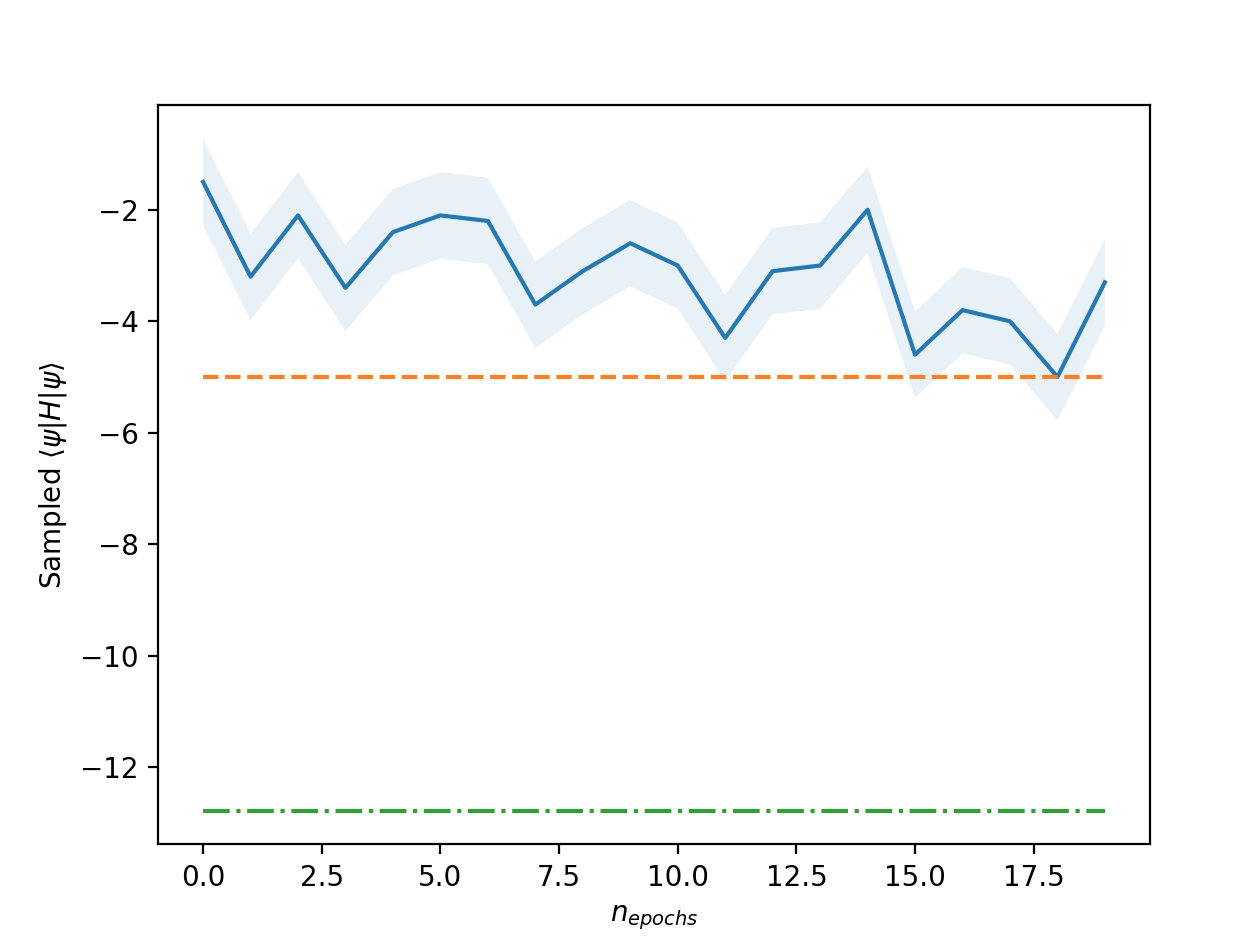


## PyTorch

PyTorch is useful to implement automatic differentiation routines and etc.

There is a qibo PyTorch backend, but in principle it has not been optimized as much

In [8]:
### PYTORCH TEST
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.4102, 0.4990, 0.1941],
        [0.2766, 0.8074, 0.1991],
        [0.4422, 0.5119, 0.0753],
        [0.8932, 0.1700, 0.3888],
        [0.6022, 0.1469, 0.3366]])


In [4]:
import matplotlib

matplotlib.__version__

'3.7.5'

In [5]:
import matplotlib.pyplot as plt

plt.plot([3,2])

: 

In [15]:
#### IN THIS CODE WE DEFINE A CLASS TO IMPLEMENT PARAMETRIZED QUANTUM CIRCUITS IN A STANDARIZED WAY

import qibo
from qibo import gates, Circuit, parameter
from qibo.symbols import I, X, Y, Z
import numpy as np

# class quantumModel():
#     """
#     Class that defines a quantum model for solving a particular problem:
#     - Number of qubits is variable, depending on model, instead the definition is the construction of the circuit"""
#     def __init__(observable, ):
#         self.parameter()

# Hamiltonian
def Hamiltonian(N, g):
    ham = I(0)*0
    for q in range(N):
        ham += Z(q)*Z((q+1)%N) + g * X(q)
    return qibo.hamiltonians.SymbolicHamiltonian(-ham)

# Parmaterized Circuit: Invariant

def circ_inv(N, p):
    params = np.random.random((2*N*p,))*np.pi
    circuit_inv = Circuit(N)
    for q in range(N):
        circuit_inv.add(gates.H(q))
    for itp in range(p):
        for itzz in range(N):
            circuit_inv.add(gates.RZZ(itzz, (itzz+1)%N, params[2*N*itp + itzz]))
        for itx in range(N):
            circuit_inv.add(gates.RX(itx, params[2*N*itp + N + itx]))
    return circuit_inv, params

def circ_noinv(N, p):
    params2 = np.random.random((3*N*p,))*np.pi
    circuit_noinv = Circuit(N)
    for q in range(N):
        circuit_noinv.add(gates.H(q))
    for itp in range(p):
        for itzz in range(N):
            circuit_noinv.add(gates.RZZ(itzz, (itzz+1)%N, params2[3*N*itp + itzz]))
        for itx in range(N):
            circuit_noinv.add(gates.RX(itx, params2[3*N*itp + N + itx]))
        for ity in range(N):
            circuit_noinv.add(gates.RY(ity, params2[3*N*itp + 2*N + ity]))
    return circuit_noinv, params2


def circs(N, p, g = 1):
    hamiltonian = Hamiltonian(N, g)
    
    circuit_inv, params = circ_inv(N,p)
    circuit_noinv, params2 = circ_noinv(N,p)

    def loss(params):
        circuit_inv.set_parameters(params)
        return hamiltonian.expectation(circuit_inv().state())

    def loss2(params):
        circuit_noinv.set_parameters(params)
        return hamiltonian.expectation(circuit_noinv().state())

    return circuit_inv, circuit_noinv, params, params2, loss, loss2


## Problem 4

# now we make a variational circuit

N = 6
p = 4
g = 1

# Hamiltonian
def Hamiltonian(N, g):
    ham = I(0)*0
    for q in range(N):
        ham += Z(q)*Z((q+1)%N) + g * X(q)
    return qibo.hamiltonians.SymbolicHamiltonian(-ham)

hamiltonian = Hamiltonian(N, g)

ground_energy = hamiltonian.eigenvalues(1)[0]

print("Exact Ground State: ", ground_energy)

# Parmaterized Circuit: Invariant
def circs(N, p):
    params = np.random.random((2*N*p,))*np.pi
    params2 = np.random.random((3*N*p,))*np.pi
    circuit_inv = Circuit(N)
    circuit_noinv = Circuit(N)
    for q in range(N):
        circuit_inv.add(gates.H(q))
        circuit_noinv.add(gates.H(q))
    for itp in range(p):
        for itzz in range(N):
            circuit_inv.add(gates.RZZ(itzz, (itzz+1)%N, params[2*N*itp + itzz]))
            circuit_noinv.add(gates.RZZ(itzz, (itzz+1)%N, params2[3*N*itp + itzz]))
        for itx in range(N):
            circuit_inv.add(gates.RX(itx, params[2*N*itp + N + itx]))
            circuit_noinv.add(gates.RX(itx, params2[3*N*itp + N + itx]))
        for ity in range(N):
            circuit_noinv.add(gates.RY(ity, params2[3*N*itp + 2*N + ity]))

    def loss(params):
        circuit_inv.set_parameters(params)
        return hamiltonian.expectation(circuit_inv().state())

    def loss2(params):
        circuit_noinv.set_parameters(params)
        return hamiltonian.expectation(circuit_noinv().state())

    return circuit_inv, circuit_noinv, params, params2, loss, loss2



Nrep = 5

plist = np.array([2,3,4,5,6,7,8])

Np = len(plist)

Elist_inv = np.empty((Np, Nrep))
Nlist_inv = np.empty((Np, Nrep))
Elist_noinv = np.empty((Np, Nrep))
Nlist_noinv = np.empty((Np, Nrep))


for itp in range(Np):
    circuit_inv, circuit_noinv, params, params2, loss, loss2 = circs(N, plist[itp])
    for itt in range(Nrep):
        params = np.random.random((2*N*plist[itp],))*np.pi
        params2 = np.random.random((3*N*plist[itp],))*np.pi
        minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")
        Elist_inv[itp,itt] = minE
        Nlist_inv[itp,itt] = scipyRes.nit

        minE, minParams, scipyRes = qibo.optimizers.optimize(loss2, params2, method = "BFGS")
        Elist_noinv[itp,itt] = minE
        Nlist_noinv[itp,itt] = scipyRes.nit

#minE, minParams, scipyRes = qibo.optimizers.optimize(loss, params, method = "BFGS")
        

print(Elist_inv)
print()
print(Nlist_inv)
print()
print(Elist_noinv)
print()
print(Nlist_noinv)


[Qibo 0.2.16|INFO|2025-05-29 09:58:55]: Using qibojit (numba) backend on /CPU:0
[Qibo 0.2.16|WARNING|2025-05-29 09:58:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Exact Ground State:  -7.72740661031255


SystemError: CPUDispatcher(<function apply_z_kernel at 0x1383ec310>) returned a result with an exception set

### Transpilation

We need to transpile our circuit to run it on an actual device

In [ ]:
import networkx as nx

from qibo import gates
from qibo.models import Circuit
from qibo.transpiler.pipeline import Passes
from qibo.transpiler.optimizer import Preprocessing
from qibo.transpiler.router import ShortestPaths
from qibo.transpiler.unroller import Unroller, NativeGates
from qibo.transpiler.placer import Random
from qibo.transpiler.asserts import assert_transpiling

# Define hardware connectivity using nx.Graph  # SIMILAR TO BSC
def star_connectivity():
    chip = nx.Graph([("q0", "q2"), ("q1", "q2"), ("q2", "q3"), ("q2", "q4")])
    return chip

# Define a custom set of native gates
gate_list = [gates.GPI2, gates.RZ, gates.Z, gates.CZ]
natives = NativeGates(0).from_gatelist(gate_list)

# Create a quantum circuit with 5 qubits
# Define the hardware qubit names to be used in wire_names
circuit = Circuit(5, wire_names=["q0", "q1", "q2", "q3", "q4"])
circuit.add(gates.H(0))
circuit.add(gates.CZ(0, 2))
circuit.add(gates.CZ(3, 4))
circuit.add(gates.X(1))

# Define a custom list of passes for the transpiler
custom_passes = [Preprocessing(), Random(), ShortestPaths(), Unroller(native_gates=natives)]

# Create a transpiler pipeline with hardware configuration
custom_pipeline = Passes(custom_passes, connectivity=star_connectivity())

# Transpile the circuit using the custom transpiler pipeline
transpiled_circ, final_layout = custom_pipeline(circuit)

# Verify that the transpiled circuit can be executed on the hardware (optional)
assert_transpiling(
    original_circuit=circuit,
    transpiled_circuit=transpiled_circ,
    connectivity=star_connectivity(),
    final_layout=final_layout,
    native_gates=NativeGates.default()
)

## PennyLane

In [45]:
import pennylane as qml

def gen_circuit(N):
    dev = qml.device("default.qubit", wires=N)

    @qml.device(dev)
    def circuit():
        qml.H(0)
        return qml.expval(0)

Example from PennyLane

In [46]:
import torch
import random

# Fix seeds for reproducability
torch.backends.cudnn.deterministic = True
torch.manual_seed(16)
random.seed(16)


#  create an empty board
def create_board():
    return torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]])


# Check for empty places on board
def possibilities(board):
    l = []
    for i in range(len(board)):
        for j in range(3):
            if board[i, j] == 0:
                l.append((i, j))
    return l


# Select a random place for the player
def random_place(board, player):
    selection = possibilities(board)
    current_loc = random.choice(selection)
    board[current_loc] = player
    return board


# Check if there is a winner by having 3 in a row
def row_win(board, player):
    for x in range(3):
        lista = []
        win = True

        for y in range(3):
            lista.append(board[x, y])

            if board[x, y] != player:
                win = False

        if win:
            break

    return win


# Check if there is a winner by having 3 in a column
def col_win(board, player):
    for x in range(3):
        win = True

        for y in range(3):
            if board[y, x] != player:
                win = False

        if win:
            break

    return win


# Check if there is a winner by having 3 along a diagonal
def diag_win(board, player):
    win1 = True
    win2 = True
    for x, y in [(0, 0), (1, 1), (2, 2)]:
        if board[x, y] != player:
            win1 = False

    for x, y in [(0, 2), (1, 1), (2, 0)]:
        if board[x, y] != player:
            win2 = False

    return win1 or win2


# Check if the win conditions have been met or if a draw has occurred
def evaluate_game(board):
    winner = None
    for player in [1, -1]:
        if row_win(board, player) or col_win(board, player) or diag_win(board, player):
            winner = player

    if torch.all(board != 0) and winner == None:
        winner = 0

    return winner


# Main function to start the game
def play_game():
    board, winner, counter = create_board(), None, 1
    while winner == None:
        for player in [1, -1]:
            board = random_place(board, player)
            counter += 1
            winner = evaluate_game(board)
            if winner != None:
                break

    return [board.flatten(), winner]


def create_dataset(size_for_each_winner):
    game_d = {-1: [], 0: [], 1: []}

    while min([len(v) for k, v in game_d.items()]) < size_for_each_winner:
        board, winner = play_game()
        if len(game_d[winner]) < size_for_each_winner:
            game_d[winner].append(board)

    res = []
    for winner, boards in game_d.items():
        res += [(board, winner) for board in boards]

    return res


NUM_TRAINING = 450
NUM_VALIDATION = 600

# Create datasets but with even numbers of each outcome
with torch.no_grad():
    dataset = create_dataset(NUM_TRAINING // 3)
    dataset_val = create_dataset(NUM_VALIDATION // 3)

In [47]:
import pennylane as qml
import matplotlib.pyplot as plt

# Set up a nine-qubit system
dev = qml.device("default.qubit", wires=9)

ob_center = qml.PauliZ(4)
ob_corner = (qml.PauliZ(0) + qml.PauliZ(2) + qml.PauliZ(6) + qml.PauliZ(8)) * (1 / 4)
ob_edge = (qml.PauliZ(1) + qml.PauliZ(3) + qml.PauliZ(5) + qml.PauliZ(7)) * (1 / 4)


# Now let's encode the data in the following qubit models, first with symmetry
@qml.qnode(dev)
def circuit(x, p):

    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)
    qml.RX(x[3], wires=3)
    qml.RX(x[4], wires=4)
    qml.RX(x[5], wires=5)
    qml.RX(x[6], wires=6)
    qml.RX(x[7], wires=7)
    qml.RX(x[8], wires=8)

    # Centre single-qubit rotation
    qml.RX(p[0], wires=4)
    qml.RY(p[1], wires=4)

    # Corner single-qubit rotation
    qml.RX(p[2], wires=0)
    qml.RX(p[2], wires=2)
    qml.RX(p[2], wires=6)
    qml.RX(p[2], wires=8)

    qml.RY(p[3], wires=0)
    qml.RY(p[3], wires=2)
    qml.RY(p[3], wires=6)
    qml.RY(p[3], wires=8)

    # Edge single-qubit rotation
    qml.RX(p[4], wires=1)
    qml.RX(p[4], wires=3)
    qml.RX(p[4], wires=5)
    qml.RX(p[4], wires=7)

    qml.RY(p[5], wires=1)
    qml.RY(p[5], wires=3)
    qml.RY(p[5], wires=5)
    qml.RY(p[5], wires=7)

    # Entagling two-qubit gates
    # circling the edge of the board
    qml.CRY(p[6], wires=[0, 1])
    qml.CRY(p[6], wires=[2, 1])
    qml.CRY(p[6], wires=[2, 5])
    qml.CRY(p[6], wires=[8, 5])
    qml.CRY(p[6], wires=[8, 7])
    qml.CRY(p[6], wires=[6, 7])
    qml.CRY(p[6], wires=[6, 3])
    qml.CRY(p[6], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[7], wires=[4, 0])
    qml.CRY(p[7], wires=[4, 2])
    qml.CRY(p[7], wires=[4, 6])
    qml.CRY(p[7], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[8], wires=[1, 4])
    qml.CRY(p[8], wires=[3, 4])
    qml.CRY(p[8], wires=[5, 4])
    qml.CRY(p[8], wires=[7, 4])

    return [qml.expval(ob_center), qml.expval(ob_corner), qml.expval(ob_edge)]


fig, ax = qml.draw_mpl(circuit)([0] * 9, 18 * [0])

In [48]:
@qml.qnode(dev)
def circuit_no_sym(x, p):

    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)
    qml.RX(x[3], wires=3)
    qml.RX(x[4], wires=4)
    qml.RX(x[5], wires=5)
    qml.RX(x[6], wires=6)
    qml.RX(x[7], wires=7)
    qml.RX(x[8], wires=8)

    # Centre single-qubit rotation
    qml.RX(p[0], wires=4)
    qml.RY(p[1], wires=4)

    # Note in this circuit the parameters aren't all the same.
    # Previously they were identical to ensure they were applied
    # as one combined gate. The fact they can all vary independently
    # here means we aren't respecting the symmetry.

    # Corner single-qubit rotation
    qml.RX(p[2], wires=0)
    qml.RX(p[3], wires=2)
    qml.RX(p[4], wires=6)
    qml.RX(p[5], wires=8)

    qml.RY(p[6], wires=0)
    qml.RY(p[7], wires=2)
    qml.RY(p[8], wires=6)
    qml.RY(p[9], wires=8)

    # Edge single-qubit rotation
    qml.RX(p[10], wires=1)
    qml.RX(p[11], wires=3)
    qml.RX(p[12], wires=5)
    qml.RX(p[13], wires=7)

    qml.RY(p[14], wires=1)
    qml.RY(p[15], wires=3)
    qml.RY(p[16], wires=5)
    qml.RY(p[17], wires=7)

    # Entagling two-qubit gates
    # circling the edge of the board
    qml.CRY(p[18], wires=[0, 1])
    qml.CRY(p[19], wires=[2, 1])
    qml.CRY(p[20], wires=[2, 5])
    qml.CRY(p[21], wires=[8, 5])
    qml.CRY(p[22], wires=[8, 7])
    qml.CRY(p[23], wires=[6, 7])
    qml.CRY(p[24], wires=[6, 3])
    qml.CRY(p[25], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[26], wires=[4, 0])
    qml.CRY(p[27], wires=[4, 2])
    qml.CRY(p[28], wires=[4, 6])
    qml.CRY(p[29], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[30], wires=[1, 4])
    qml.CRY(p[31], wires=[3, 4])
    qml.CRY(p[32], wires=[5, 4])
    qml.CRY(p[33], wires=[7, 4])

    return [qml.expval(ob_center), qml.expval(ob_corner), qml.expval(ob_edge)]


fig, ax = qml.draw_mpl(circuit_no_sym)([0] * 9, [0] * 34)

In [49]:
# calculate the mean square error for this classification problem
def cost_function(params, input, target):
    output = torch.stack([torch.hstack(circuit(x, params)) for x in input])
    vec = output - target
    sum_sqr = torch.sum(vec * vec, dim=1)
    return torch.mean(sum_sqr)

In [50]:
from torch import optim
import numpy as np

params = 0.01 * torch.randn(9)
params.requires_grad = True
opt = optim.Adam([params], lr=1e-2)


max_epoch = 15
max_step = 30
batch_size = 10

encoded_dataset = list(zip(*[encode_game(game) for game in dataset]))
encoded_dataset_val = list(zip(*[encode_game(game) for game in dataset_val]))


def accuracy(p, x_val, y_val):
    with torch.no_grad():
        y_val = torch.tensor(y_val)
        y_out = torch.stack([torch.hstack(circuit(x, p)) for x in x_val])
        acc = torch.sum(torch.argmax(y_out, axis=1) == torch.argmax(y_val, axis=1))
        return acc / len(x_val)


print(f"accuracy without training = {accuracy(params, *encoded_dataset_val)}")

x_dataset = torch.stack(encoded_dataset[0])
y_dataset = torch.tensor(encoded_dataset[1], requires_grad=False)

saved_costs_sym = []
saved_accs_sym = []
for epoch in range(max_epoch):
    rand_idx = torch.randperm(len(x_dataset))
    # Shuffled dataset
    x_dataset = x_dataset[rand_idx]
    y_dataset = y_dataset[rand_idx]

    costs = []

    for step in range(max_step):
        x_batch = x_dataset[step * batch_size : (step + 1) * batch_size]
        y_batch = y_dataset[step * batch_size : (step + 1) * batch_size]

        def opt_func():
            opt.zero_grad()
            loss = cost_function(params, x_batch, y_batch)
            costs.append(loss.item())
            loss.backward()
            return loss

        opt.step(opt_func)

    cost = np.mean(costs)
    saved_costs_sym.append(cost)

    if (epoch + 1) % 1 == 0:
        # Compute validation accuracy
        acc_val = accuracy(params, *encoded_dataset_val)
        saved_accs_sym.append(acc_val)

        res = [epoch + 1, cost, acc_val]
        print("Epoch: {:2d} | Loss: {:3f} | Validation accuracy: {:3f}".format(*res))

NameError: name 'encode_game' is not defined

[Qibo 0.2.16|WARNING|2025-05-08 17:32:25]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Exact Ground State:  -7.72740661031255
P:  0 ,rep 0


SystemError: CPUDispatcher(<function apply_gate_kernel at 0x13952a440>) returned a result with an exception set

### More ideas from Pennylane and otherwise:

Stochastic gradient descent, using shots, converges! https://arxiv.org/pdf/1910.01155


https://pennylane.ai/qml/demos/tutorial_stochastic_parameter_shift

https://pennylane.ai/qml/demos/tutorial_doubly_stochastic



Also: Qibo paper implementing psr
https://cds.cern.ch/record/2847576/files/2210.10787.pdf


### Interesting reads

Diagnosing Barren Plateaus with Tools from Quantum Optimal Control
https://arxiv.org/pdf/2105.14377


Training variational quantum algorithms is NP-hard
https://arxiv.org/pdf/2101.07267


Quantum Analytic Descent
https://arxiv.org/pdf/2008.13774